In [1]:
## purpose: to render out all intermediate sketches to be able to get feature vector for all intermediate sketches
## jefan
## June 22 2017

In [8]:
from __future__ import division

import numpy as np
from numpy import *

import os

import PIL
from PIL import Image
import matplotlib.pyplot as plt

from skimage import data, io, filters

from matplotlib.path import Path
import matplotlib.patches as patches

import pandas as pd
import helpers as helpers

In [3]:
path_to_strokes =  "tiny/airplane.npy"
X = np.load(path_to_strokes)[()]

In [4]:
print('Example sketch has ', str(shape(X['airplane'][0][0])[0]), ' strokes')
print('Corresponds to photo: ', X['airplane'][1][0])

path_to_source_photos = "/home/jefan/pix2svg/tiny/photo/airplane/"
photo = os.path.join(path_to_source_photos,'n02691156_10151.jpg')

('Example sketch has ', '169', ' strokes')
('Corresponds to photo: ', 'n02691156_10151')


In [94]:
class TinyDataset():
    """tiny airplane dataset of photos and sketches for pix2svg."""

    def __init__(self, npy_file, root_dir, transform=None):
        """
        Args:
            npy_file (string): Path to the numpy file with stroke-5 representation and corresponding photos.
                    # to get stroke-5 representation of svg
                    x['airplane'][0][5]
                    # to get corresponding photos
                    x['airplane'][1][5]
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.stroke_dir = npy_file
        self.photo_dir = os.path.join(root_dir,'photo')
        self.stroke_numpy = np.load(os.path.join(root_dir,'airplane.npy'))[()]
        self.strokes = np.load(npy_file)[()]
        self.transform = transform
    
    def __len__(self):
        return len(self.strokes['airplane'][0])

    def __getitem__(self, idx):
        X = self.stroke_numpy
        img_name = os.path.join(self.photo_dir,'airplane',X['airplane'][1][idx]+ '.jpg')
        photo = io.imread(img_name)
        photo = photo.astype(float)
        strokes = self.strokes['airplane'][0][idx]
        sample = {'photo': photo, 'strokes': strokes,'name': X['airplane'][1][idx]+ '.jpg'}
        
        if self.transform:
            sample = self.transform(sample)

        return sample    

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, strokes, name = sample['photo'], sample['strokes'], sample['name']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))        
        return {'tensor': tf.divide(tf.stack(sample['photo']),255),
                'strokes': strokes,
                'name': name,
                'photo': image}    

def to_normal_strokes(big_stroke):
    """Convert from stroke-5 format (from sketch-rnn paper) back to stroke-3."""
    l = 0
    for i in range(len(big_stroke)):
        if big_stroke[i, 4] > 0:
            l = i
            break
    if l == 0:
        l = len(big_stroke)
    result = np.zeros((l, 3))
    result[:, 0:2] = big_stroke[0:l, 0:2]
    result[:, 2] = big_stroke[0:l, 3]
    return result    
    
def strokes_to_lines(strokes):
    """
    Convert stroke-3 format to polyline format.
    List contains sublist of continuous line segments (strokes).    
    """
    x = 0
    y = 0
    lines = []
    line = []
    for i in range(len(strokes)):
        if strokes[i, 2] == 1:
            x += float(strokes[i, 0])
            y += float(strokes[i, 1])
            line.append([x, y])
            lines.append(line)
            line = []
        else:
            x += float(strokes[i, 0])
            y += float(strokes[i, 1])
            line.append([x, y])
    return lines

def polyline_pathmaker(lines):
    x = []
    y = []

    codes = [Path.MOVETO] # start with moveto command always
    for i,l in enumerate(lines):
        for _i,_l in enumerate(l):
            x.append(_l[0])
            y.append(_l[1])
            if _i<len(l)-1:
                codes.append(Path.LINETO) # keep pen on page
            else:
                if i != len(lines)-1: # final vertex
                    codes.append(Path.MOVETO)
    verts = zip(x,y)            
    return verts, codes

def path_renderer(verts, codes):
    if len(verts)>0:
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor='none', lw=2)
        ax.add_patch(patch)
        ax.set_xlim(0,500)
        ax.set_ylim(0,500) 
        ax.axis('off')
        plt.gca().invert_yaxis() # y values increase as you go down in image
        plt.show()
    else:
        ax.set_xlim(0,500)
        ax.set_ylim(0,500)        
        ax.axis('off')
        plt.show()

In [37]:
## load in airplanes dataset
airplanes = TinyDataset(npy_file='/home/jefan/pix2svg/tiny/airplane.npy',root_dir='/home/jefan/pix2svg/tiny',transform=None)

(1, (256, 256, 3), (90, 5))


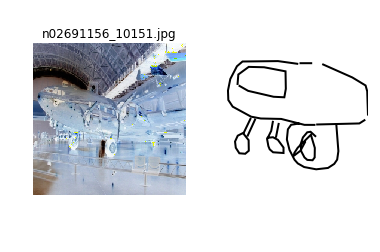

In [38]:
## display given photo and corresponding sketch from stroke-5 representation
i = 1
sample = airplanes[i]
print(i, sample['photo'].shape, sample['strokes'].shape)

plt.figure()
ax = plt.subplot(121)
ax.set_title(sample['name'])
ax.axis('off')
img = np.reshape(sample['photo'],(256,256,3))
plt.imshow(img,interpolation='nearest')

ax = plt.subplot(122)
lines = strokes_to_lines(to_normal_strokes(sample['strokes']))
verts,codes = polyline_pathmaker(lines)
path_renderer(verts,codes)

plt.show()

In [9]:
### fig save syntax: save(path, ext='png', close=True, verbose=True)

In [39]:
# render out just one
i = 1
sample = airplanes[i]
print(i, sample['photo'].shape, sample['strokes'].shape, sample['name'])

lines = strokes_to_lines(to_normal_strokes(sample['strokes']))
verts,codes = polyline_pathmaker(lines)

(1, (256, 256, 3), (90, 5), 'n02691156_10151.jpg')


In [41]:
path_to_intermediates = 'tiny_intermediates'
if not os.path.exists(os.path.join(path_to_intermediates,sample['name'].split('.')[0])):
    os.makedirs(os.path.join(path_to_intermediates,sample['name'].split('.')[0]))
# if there is not a folder corresponding to this sketch (that will contain all intermediates), then create it  


In [68]:
# matches = []
photos = []
sketchID = []
counter = 0
for i in range(len(airplanes)):
#     matches.append(airplanes[i]['name']==sample['name'])
    photos.append(airplanes[i]['name'].split('.')[0])
    if i==0:
        sketchID.append(0)
    elif airplanes[i]['name'].split('.')[0] == airplanes[i-1]['name'].split('.')[0]: # current matches previous
        counter = counter + 1
        sketchID.append(counter)
    elif airplanes[i]['name'].split('.')[0] != airplanes[i-1]['name'].split('.')[0]: # new photo dir
        counter = 0
        sketchID.append(counter)
        
# matches = np.array(matches).astype(bool)
unique_photos = np.unique(photos)
zipped = zip(photos,sketchID)

In [92]:
# if there is not a folder corresponding to this source photo, then create it
for p in unique_photos:
    if not os.path.exists(os.path.join(path_to_intermediates,p)):
        os.makedirs(os.path.join(path_to_intermediates,p))    

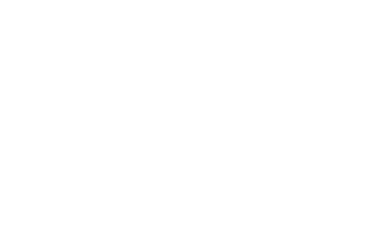

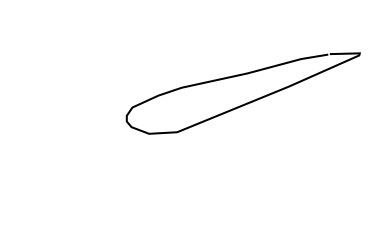

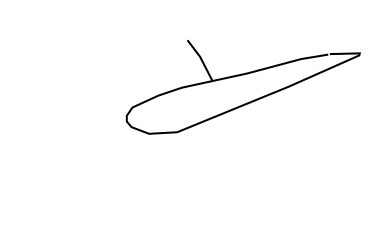

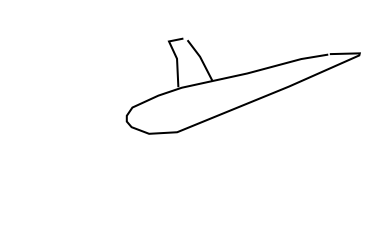

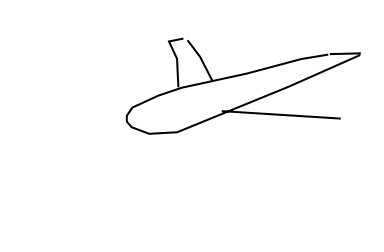

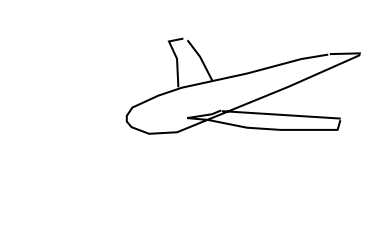

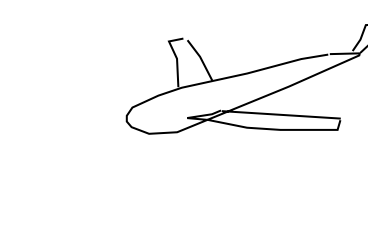

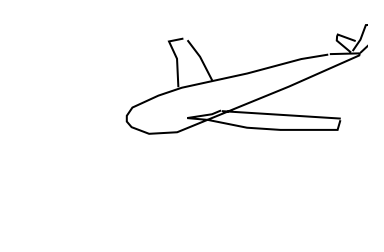

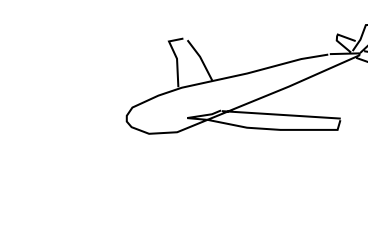

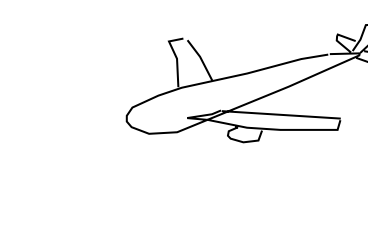

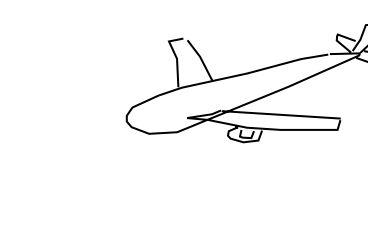

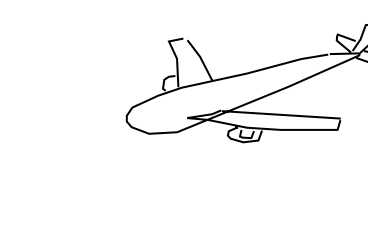

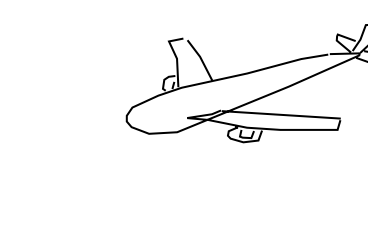

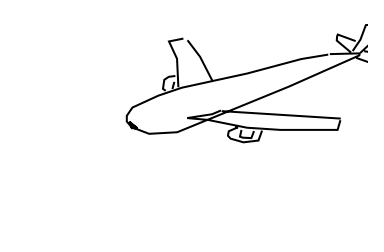

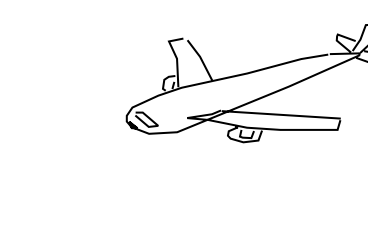

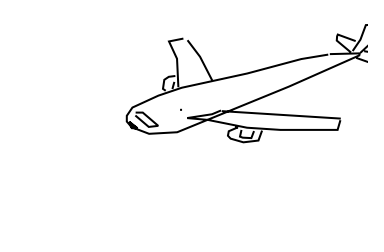

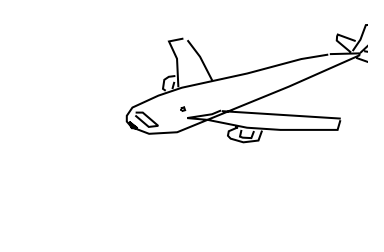

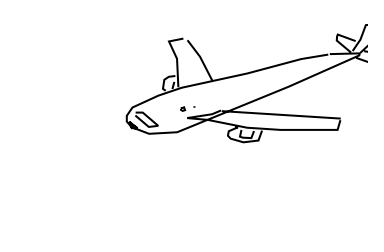

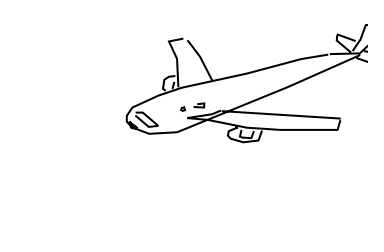

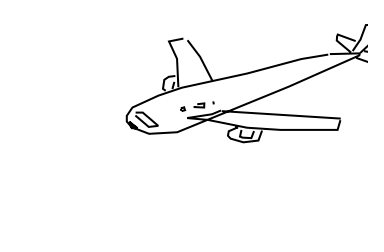

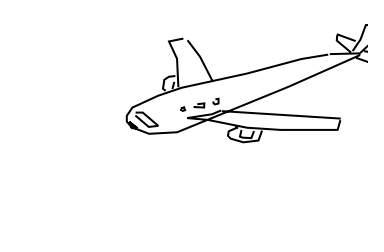

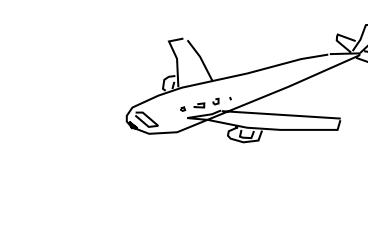

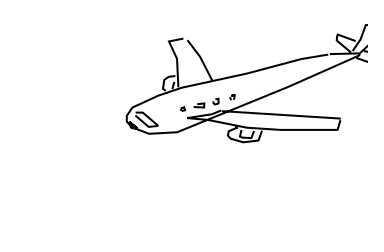

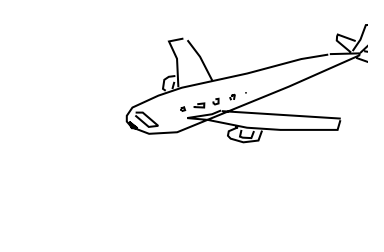

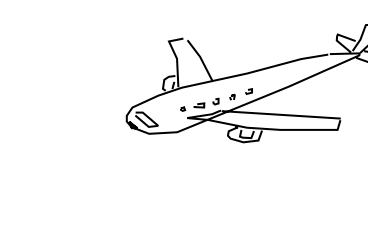

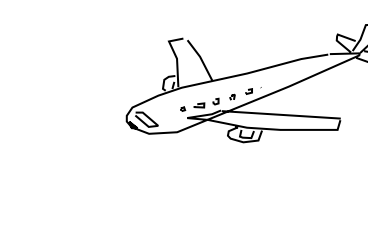

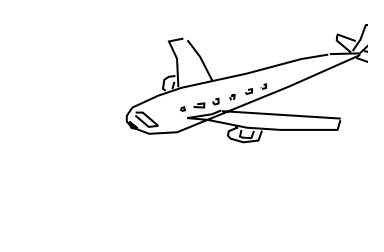

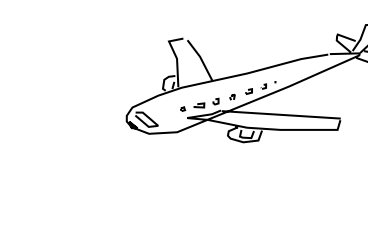

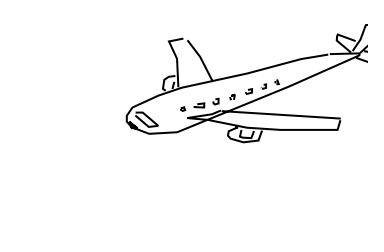

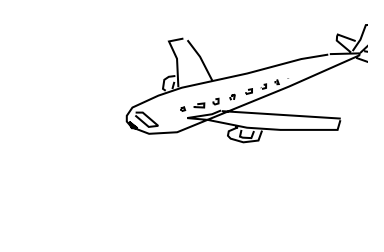

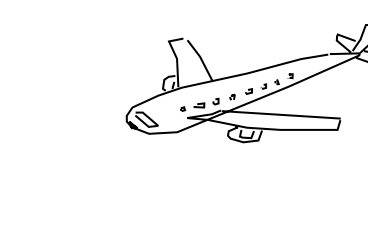

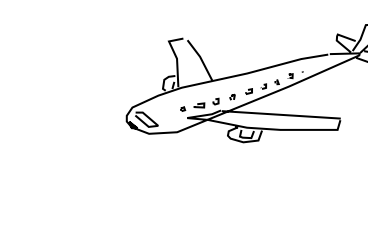

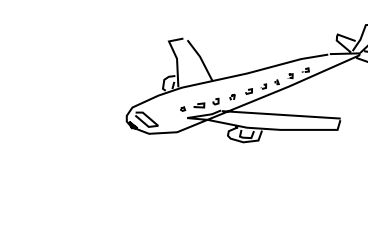

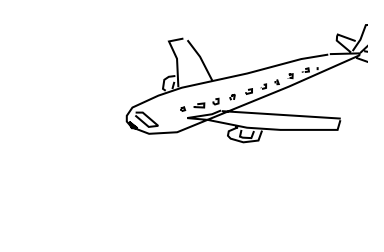

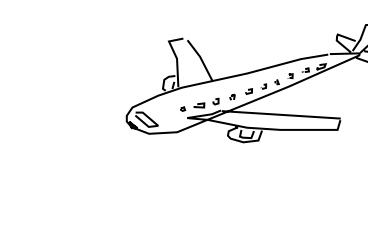

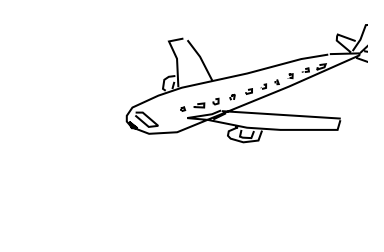

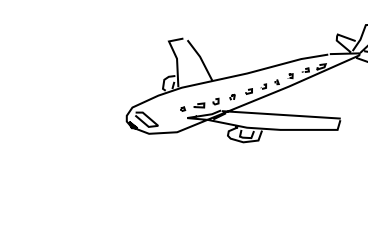

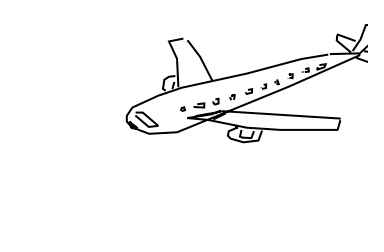

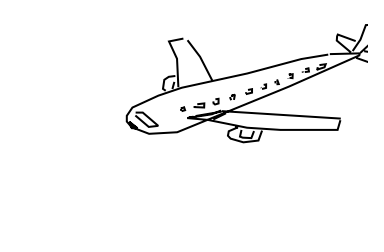

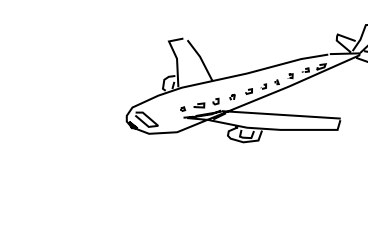

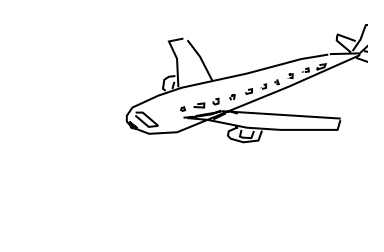

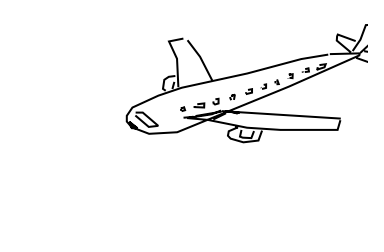

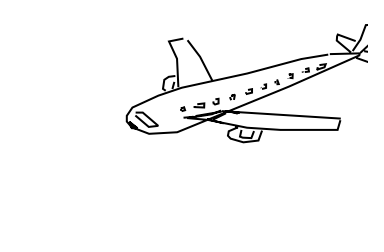

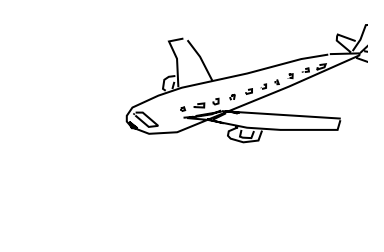

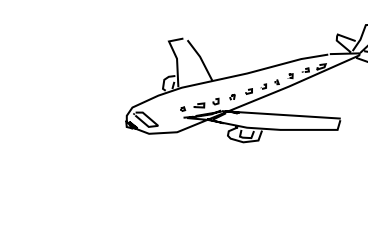

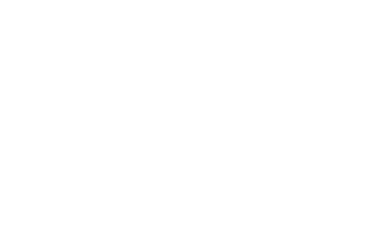

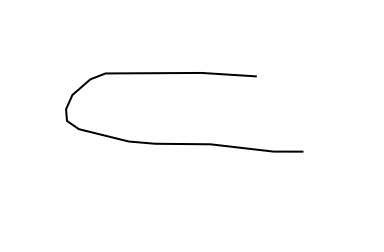

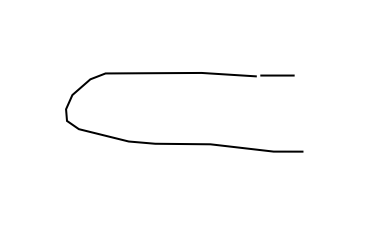

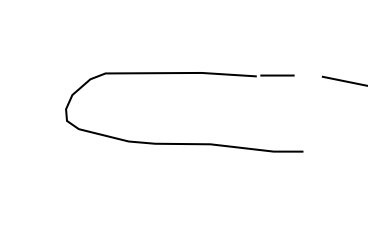

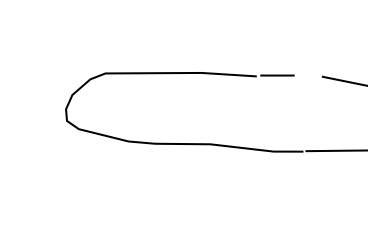

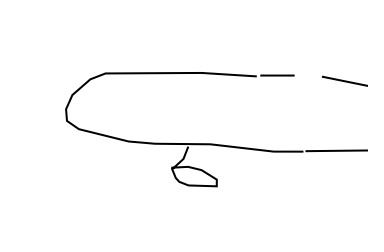

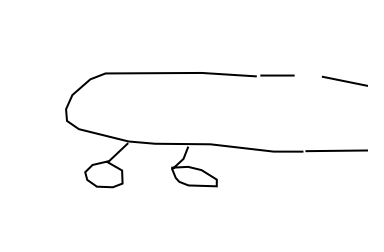

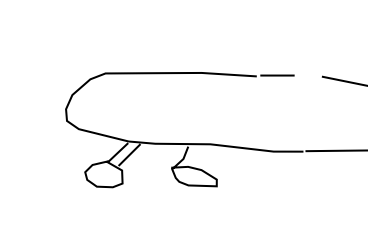

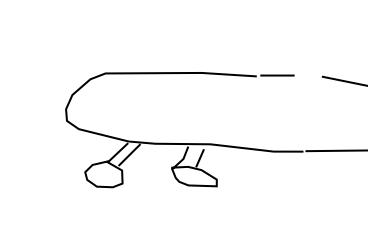

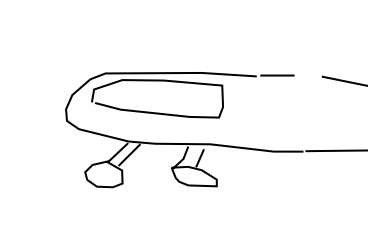

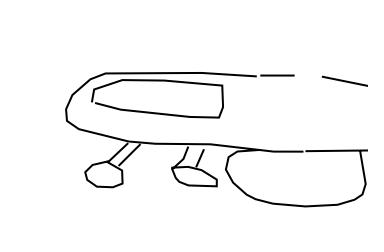

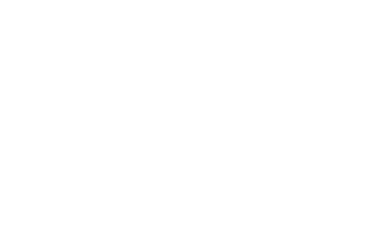

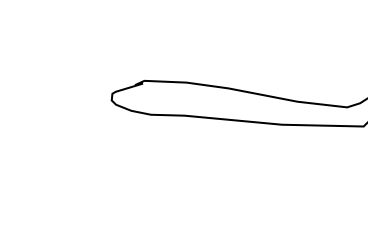

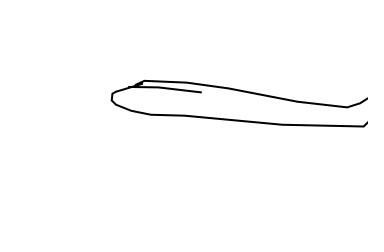

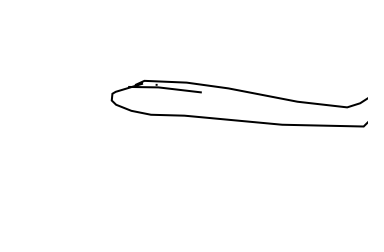

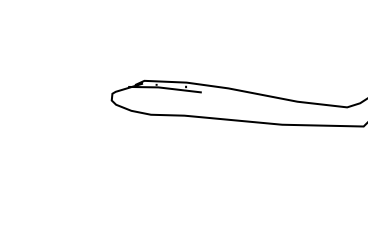

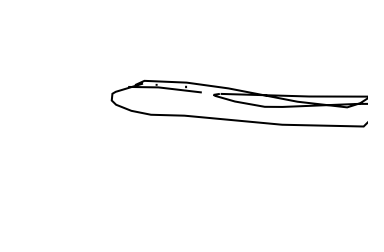

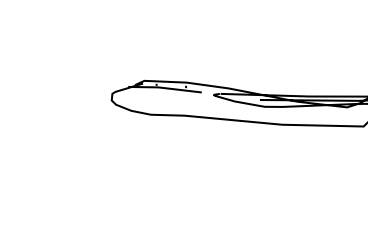

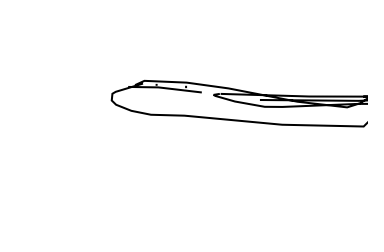

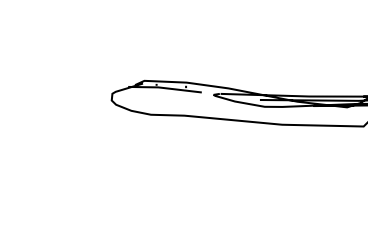

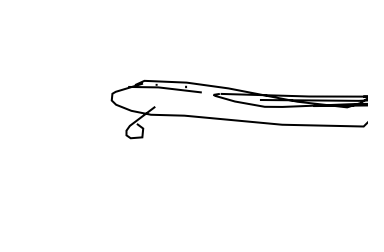

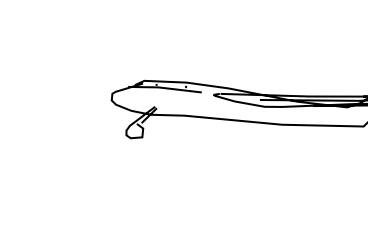

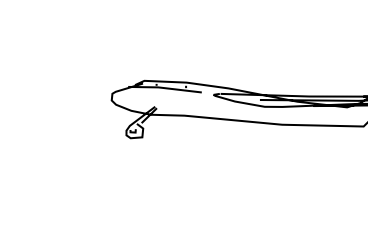

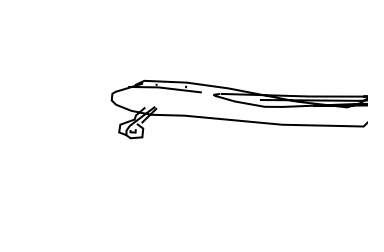

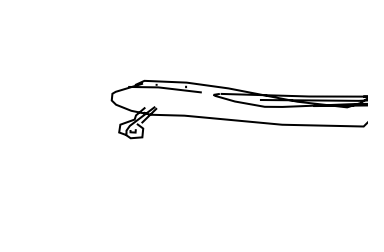

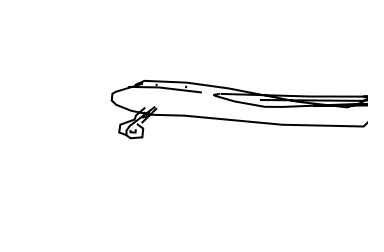

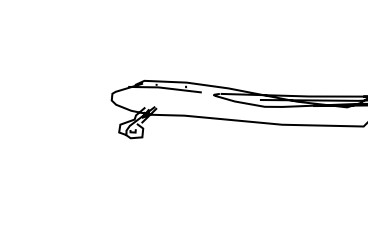

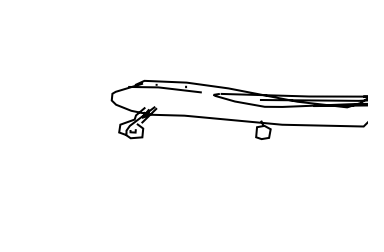

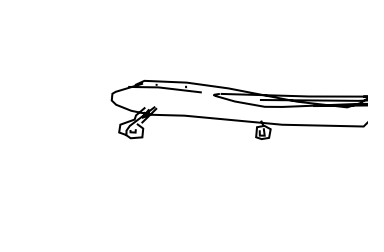

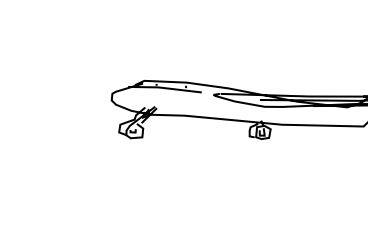

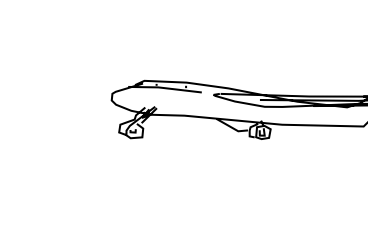

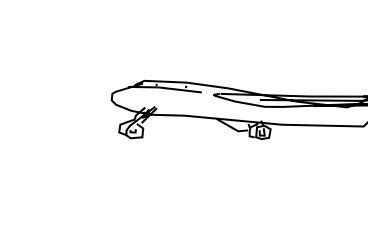

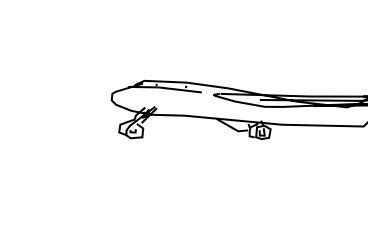

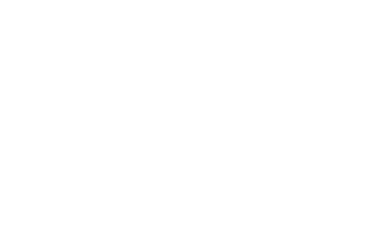

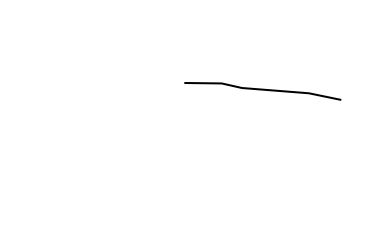

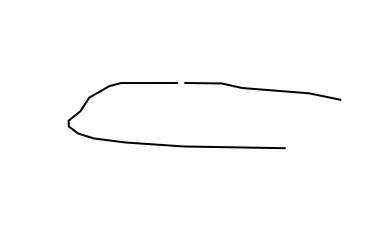

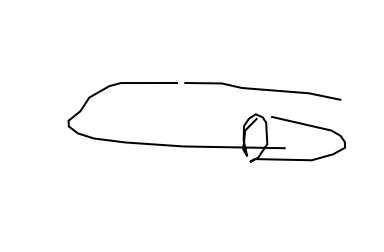

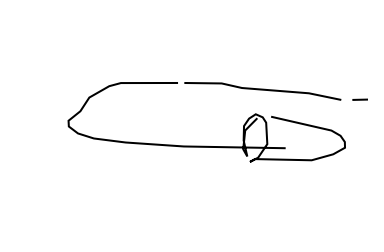

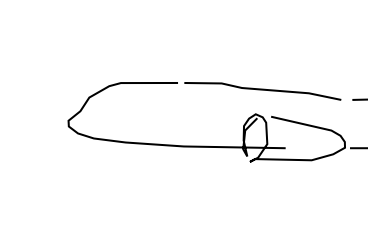

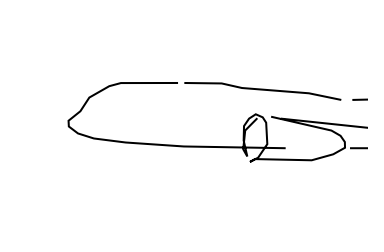

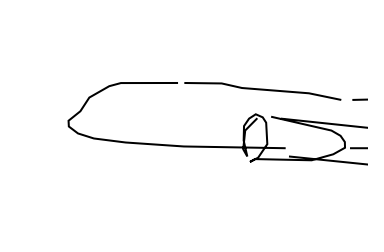

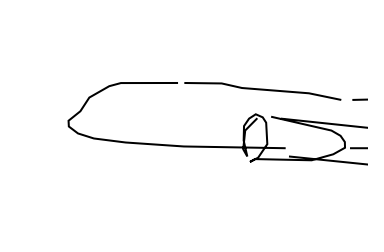

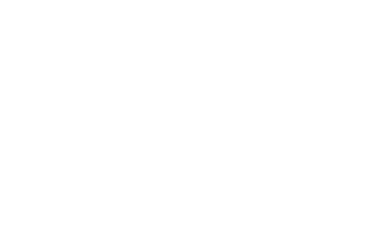

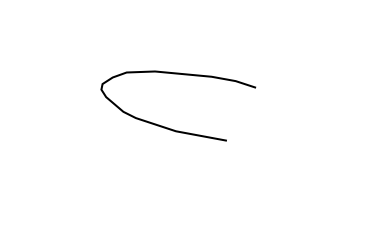

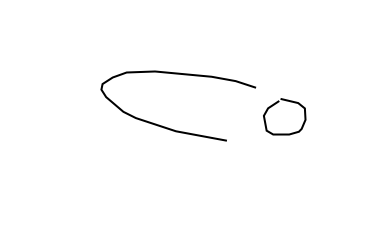

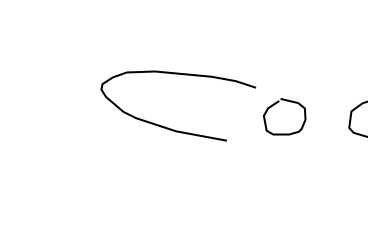

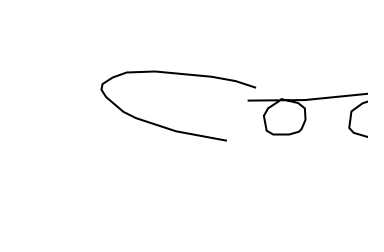

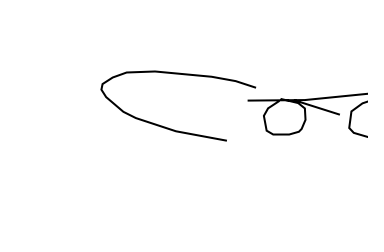

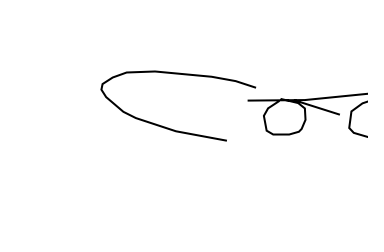

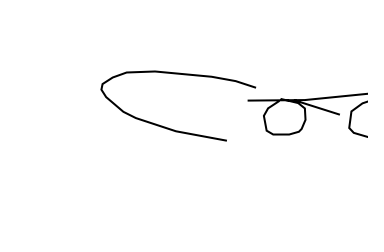

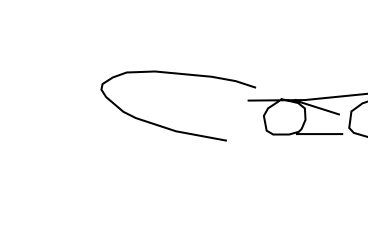

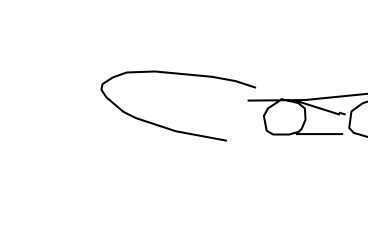

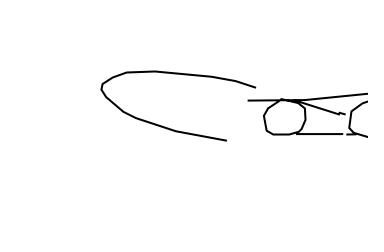

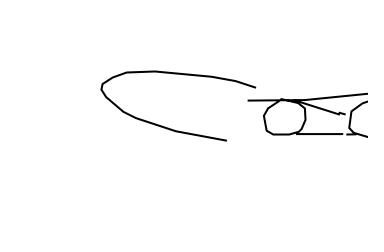

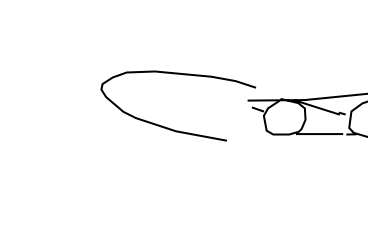

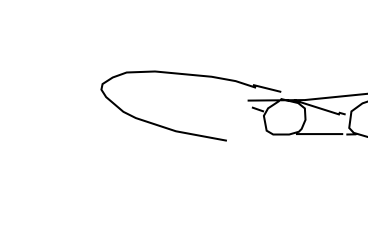

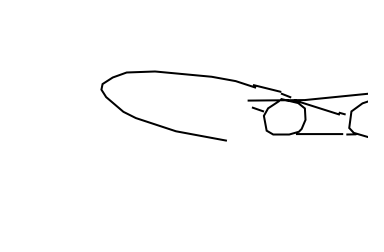

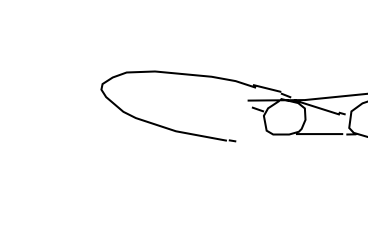

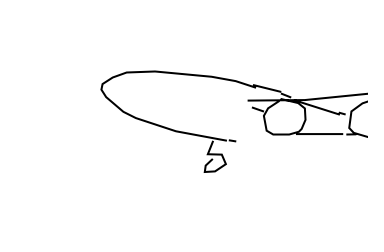

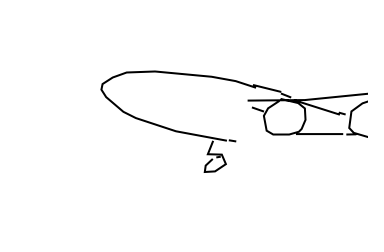

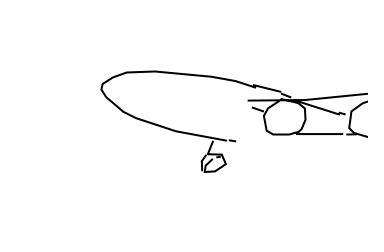

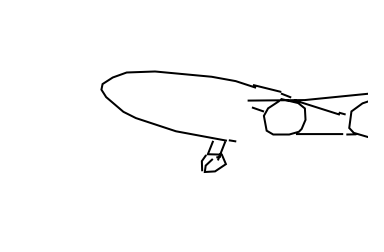

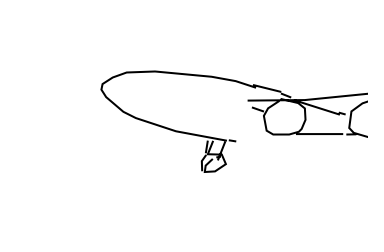

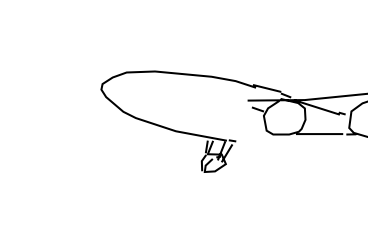

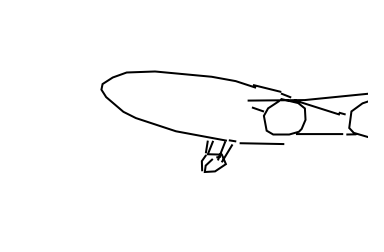

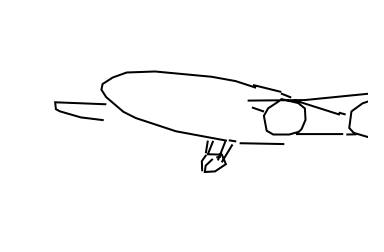

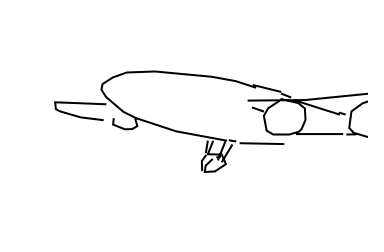

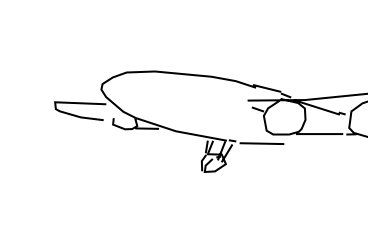

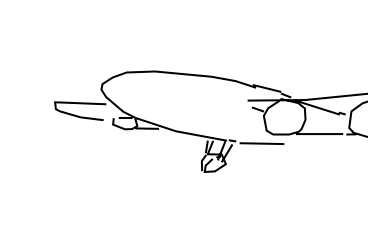

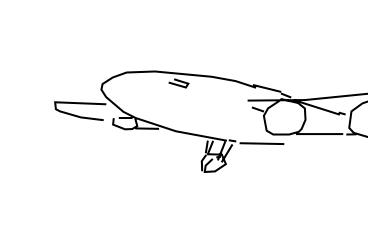

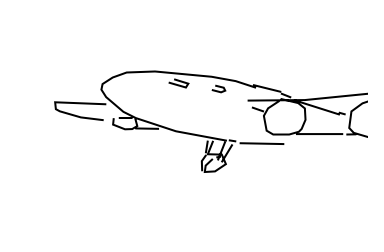

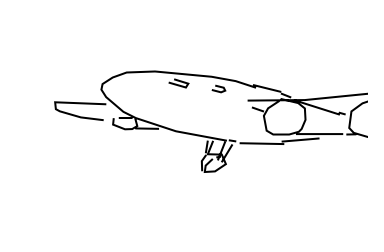

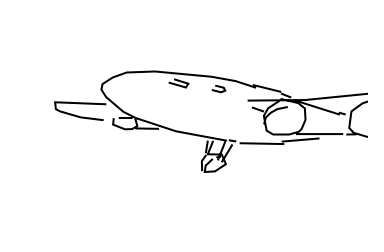

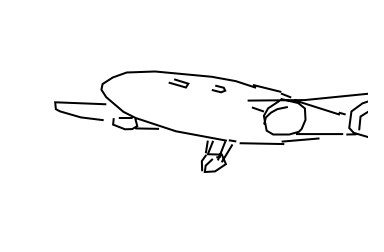

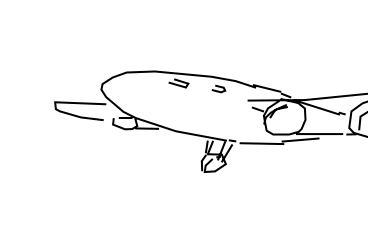

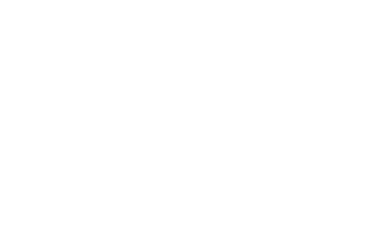

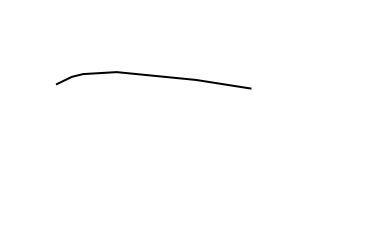

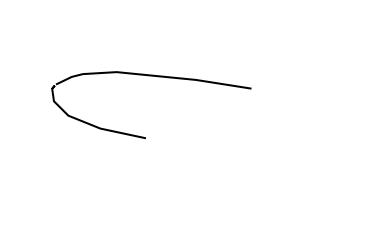

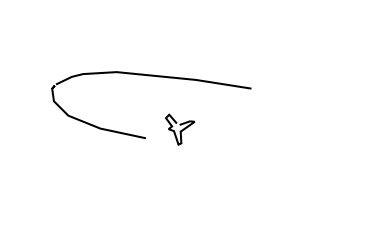

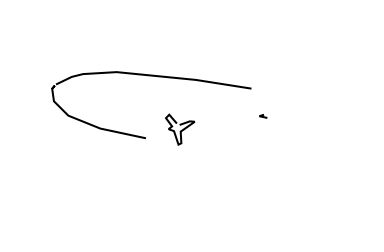

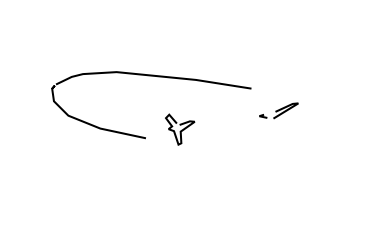

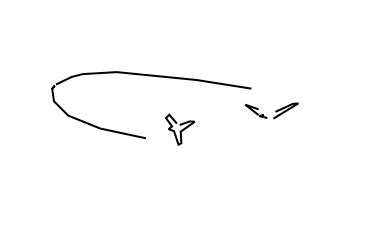

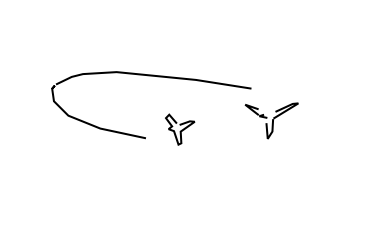

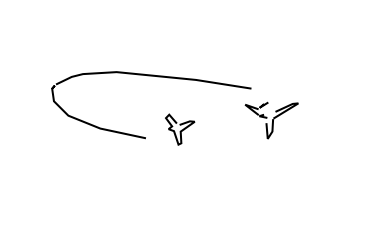

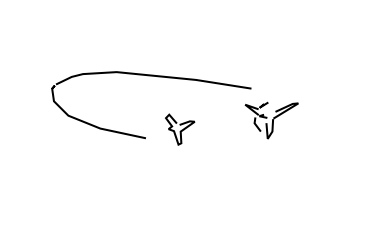

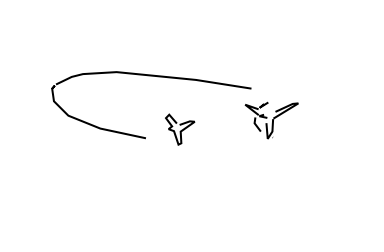

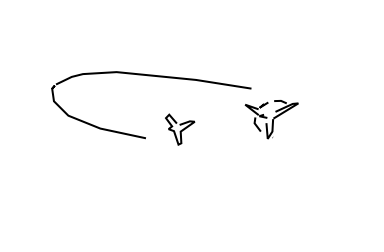

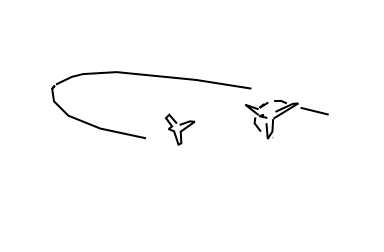

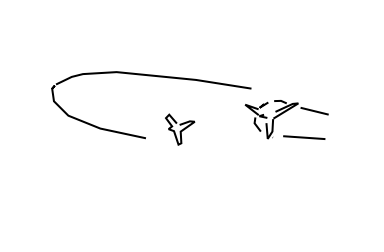

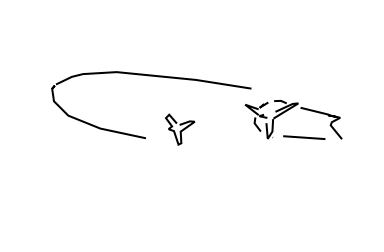

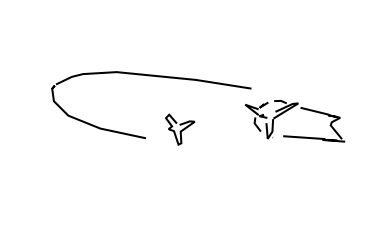

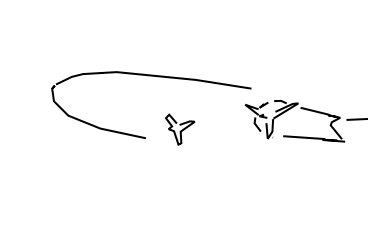

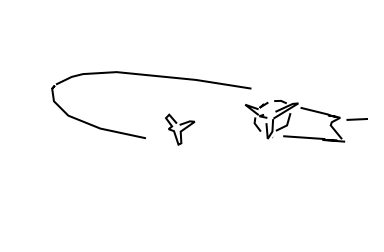

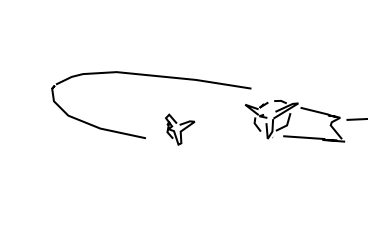

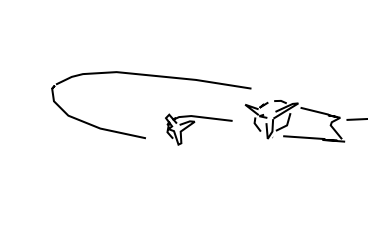

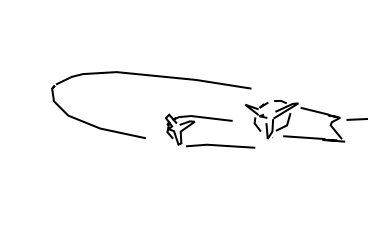

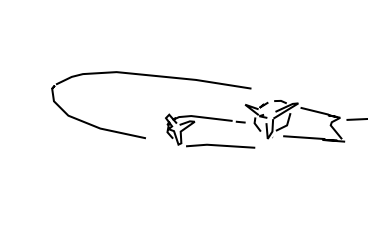

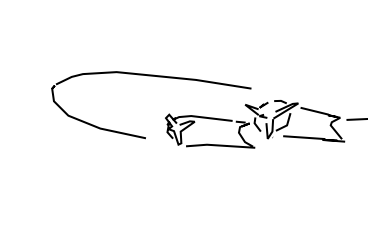

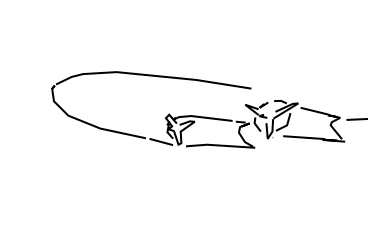

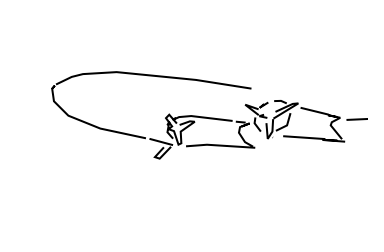

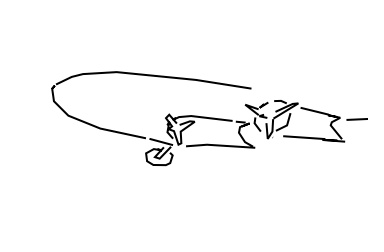

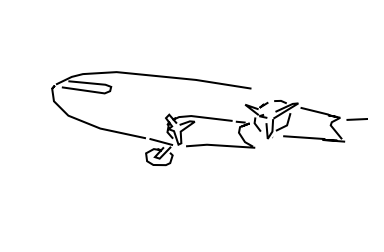

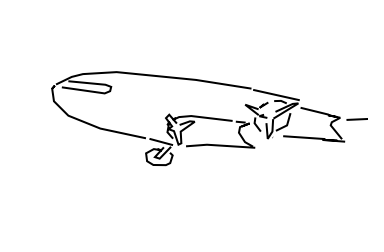

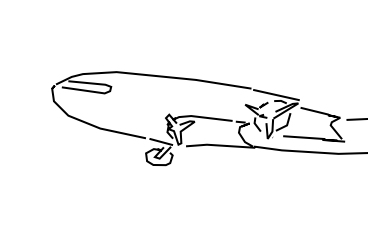

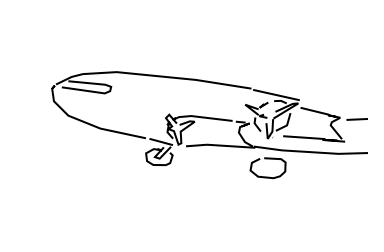

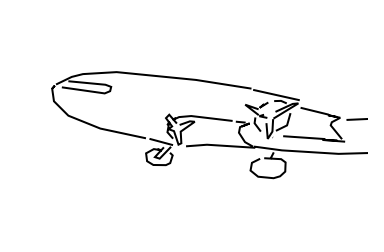

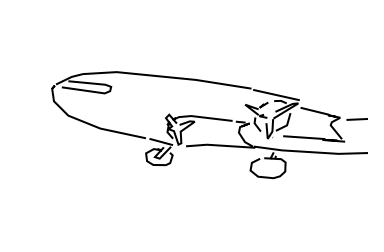

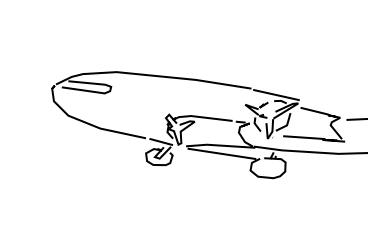

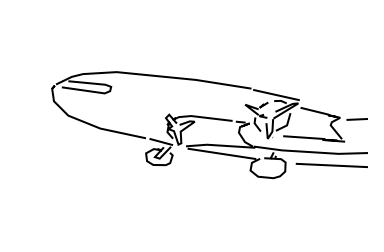

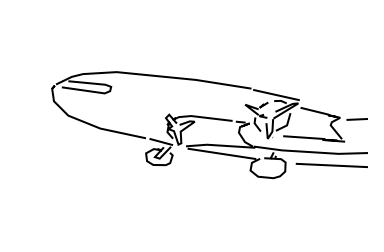

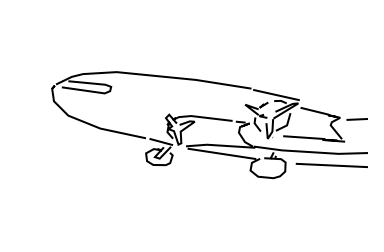

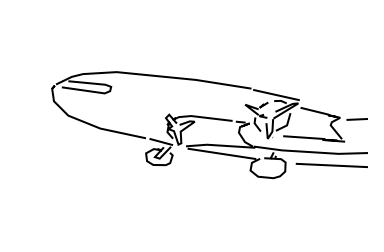

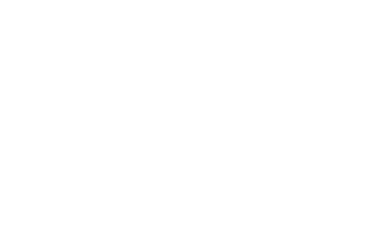

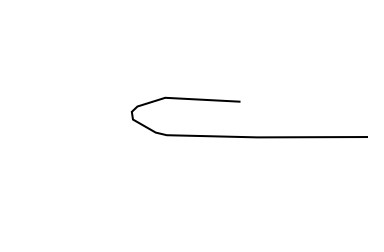

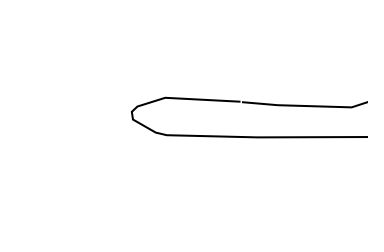

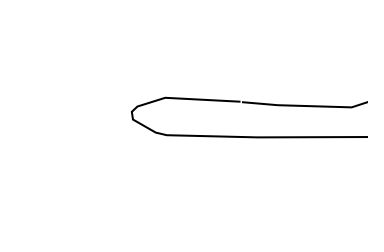

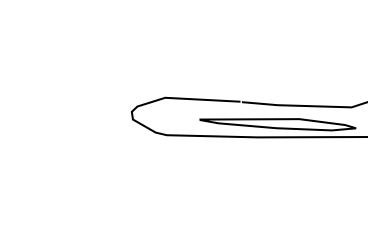

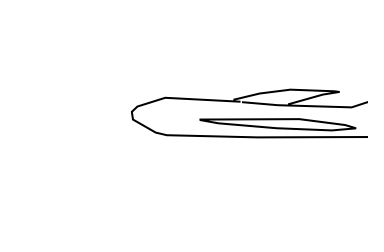

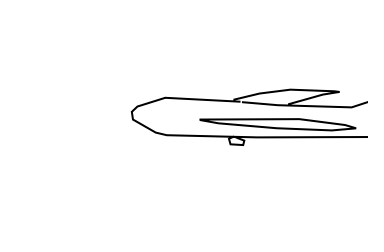

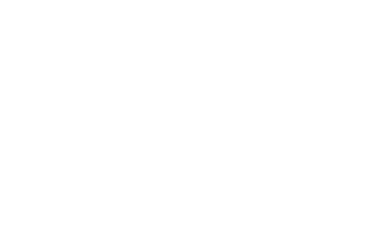

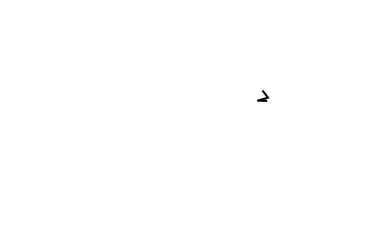

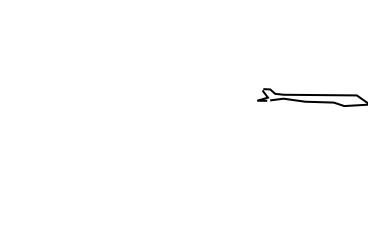

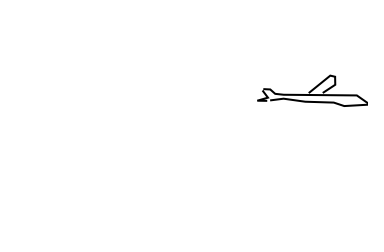

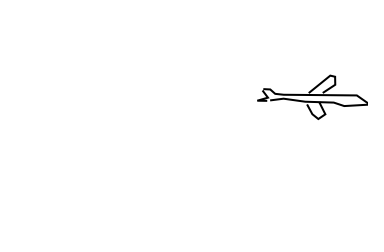

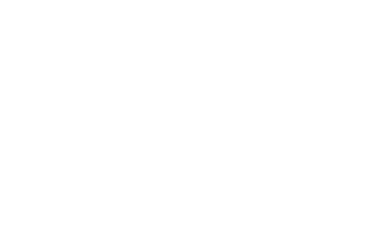

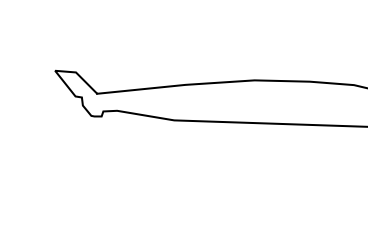

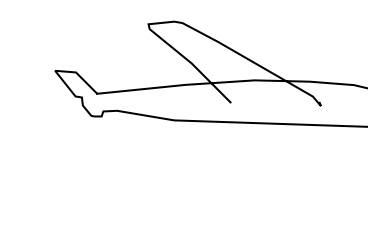

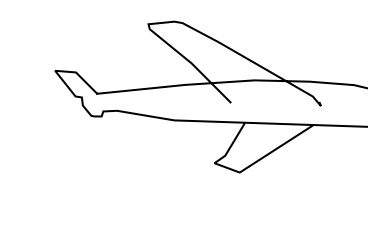

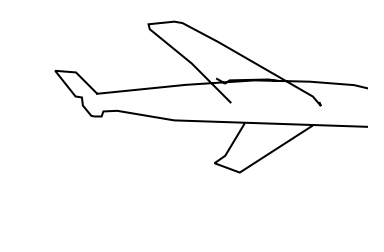

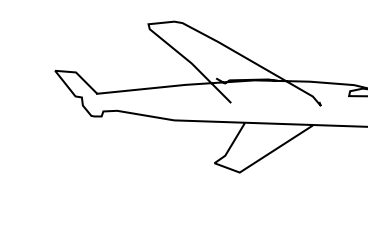

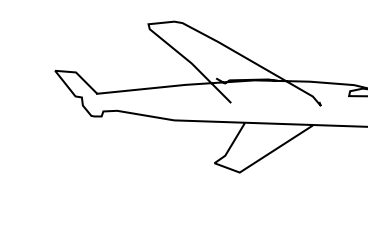

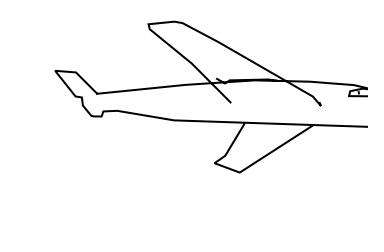

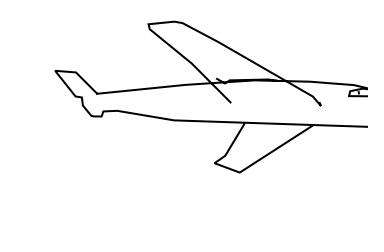

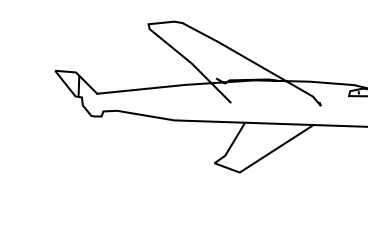

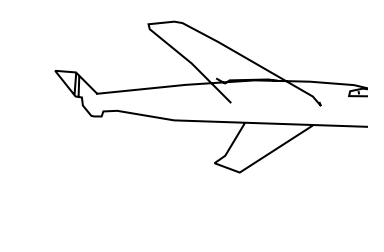

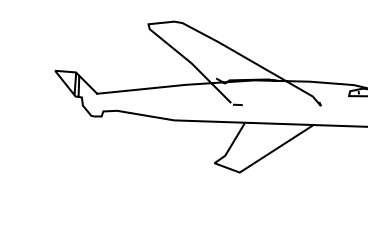

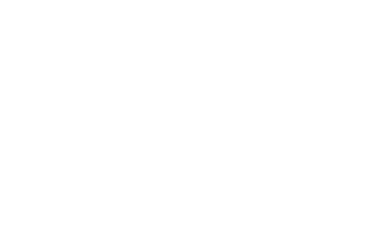

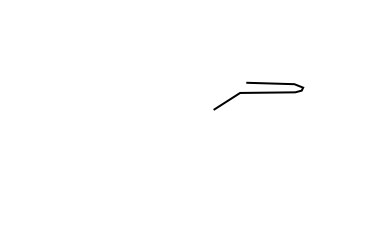

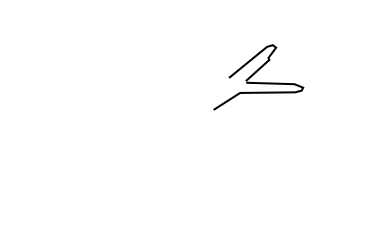

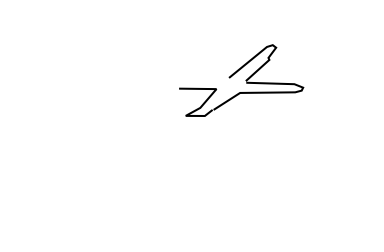

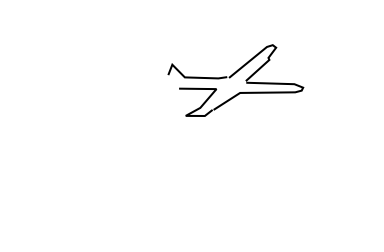

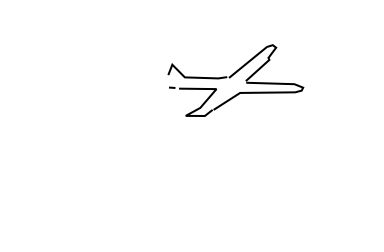

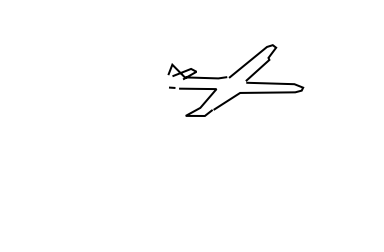

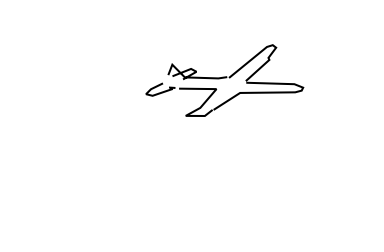

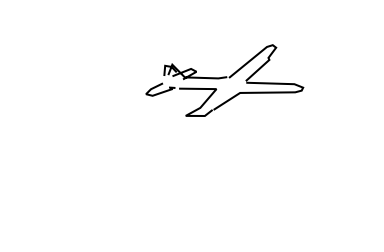

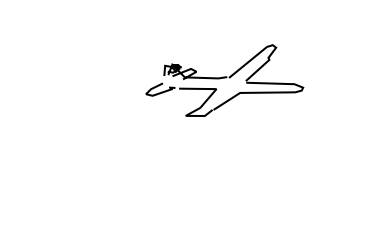

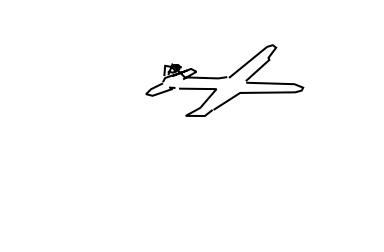

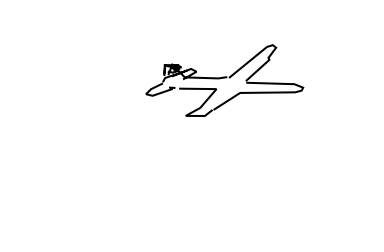

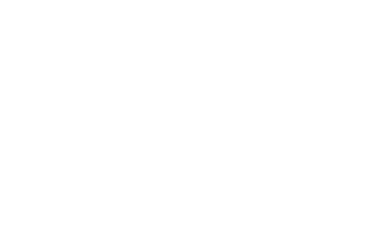

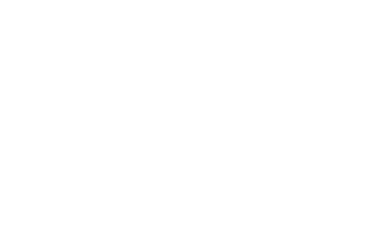

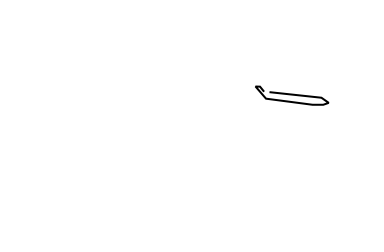

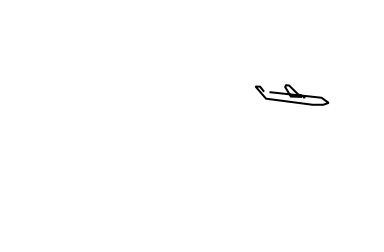

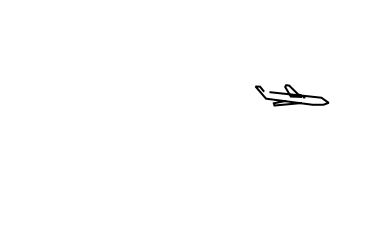

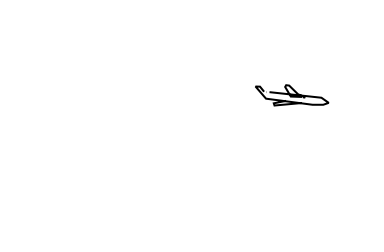

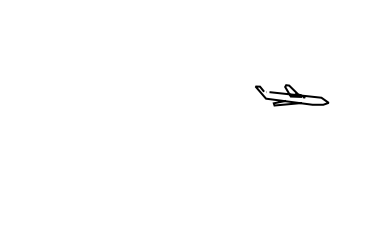

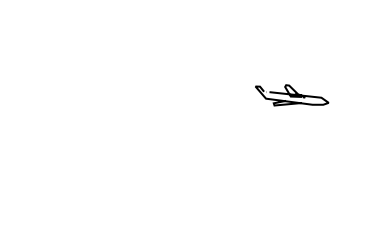

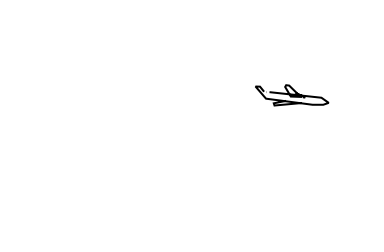

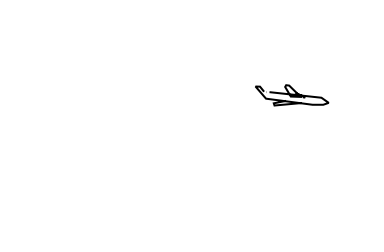

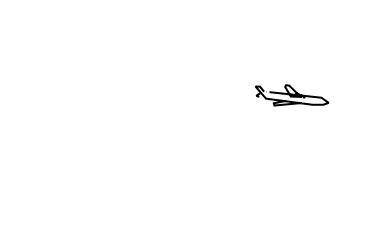

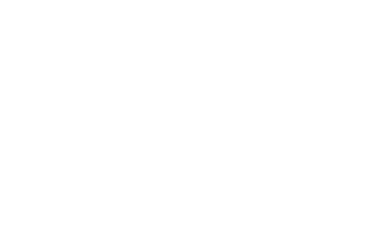

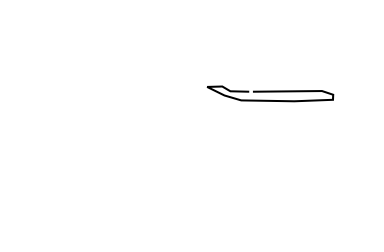

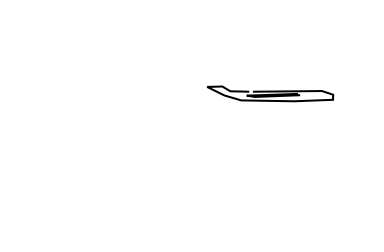

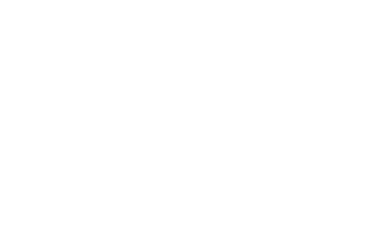

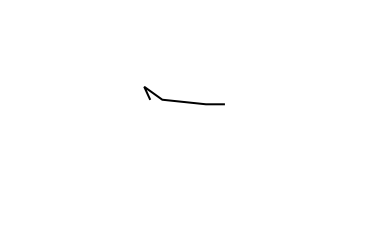

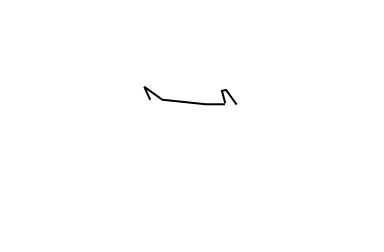

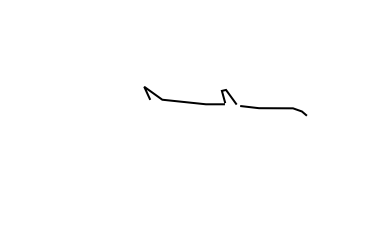

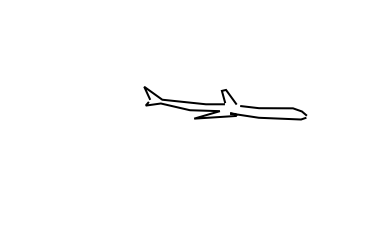

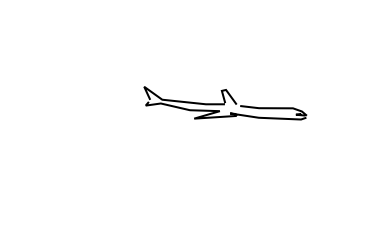

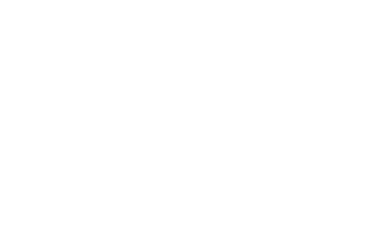

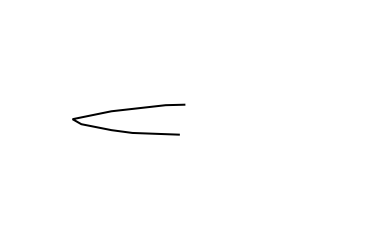

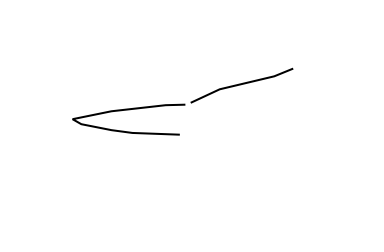

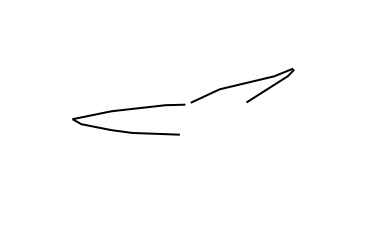

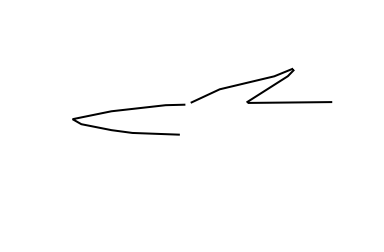

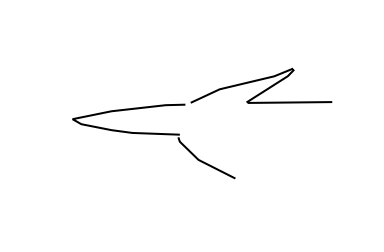

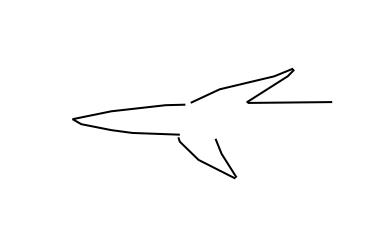

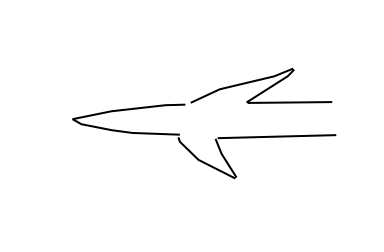

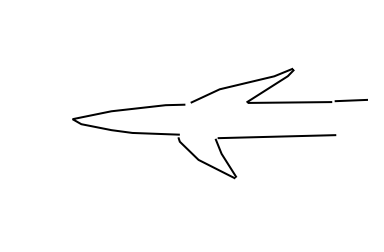

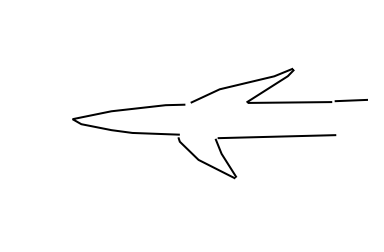

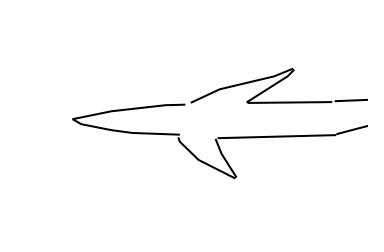

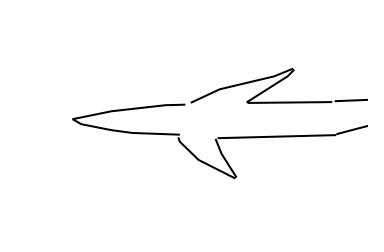

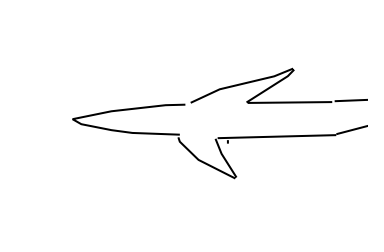

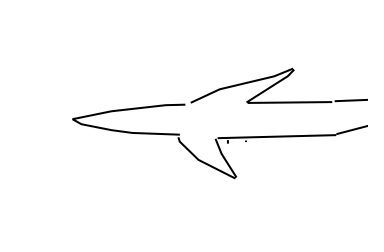

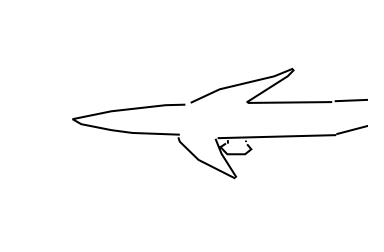

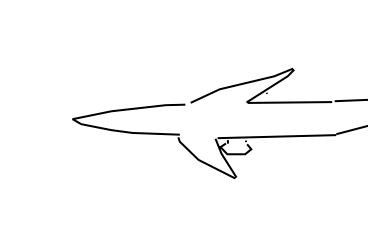

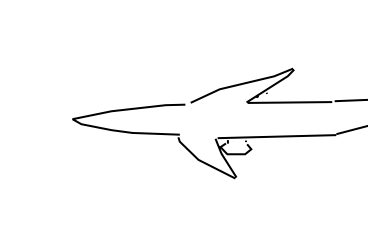

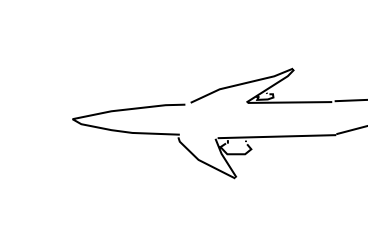

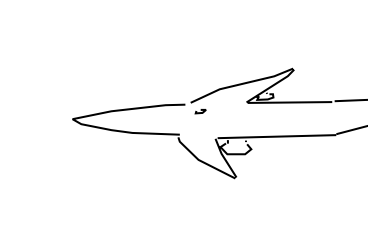

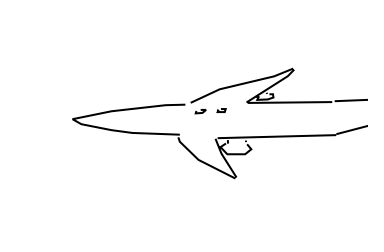

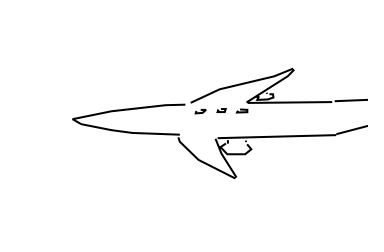

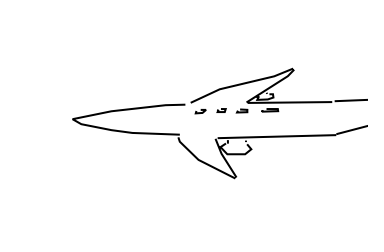

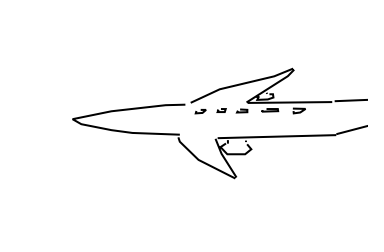

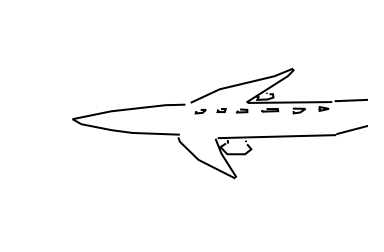

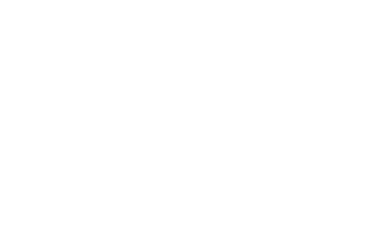

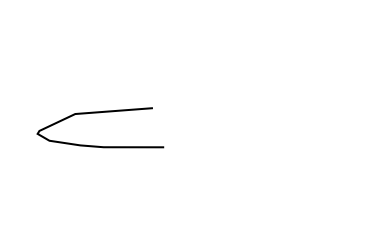

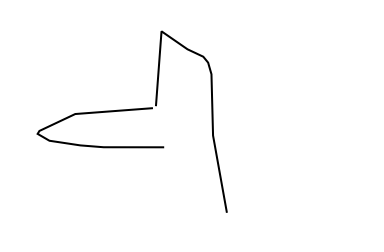

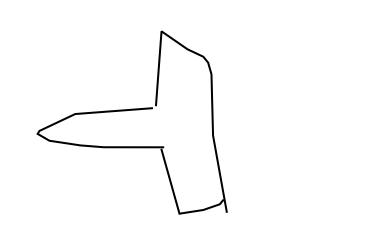

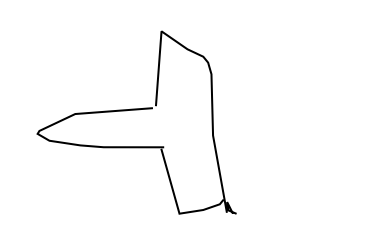

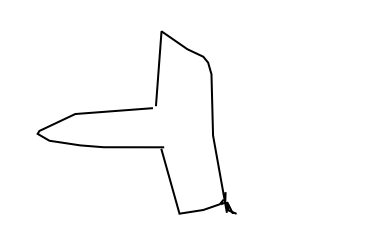

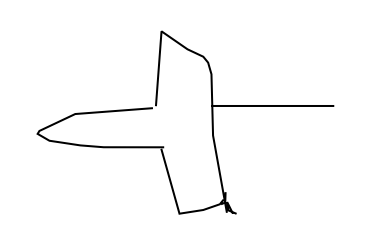

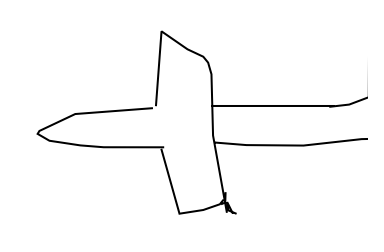

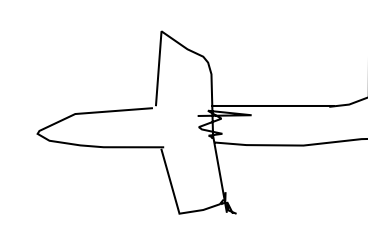

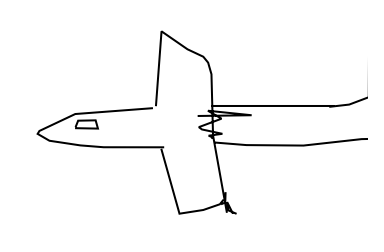

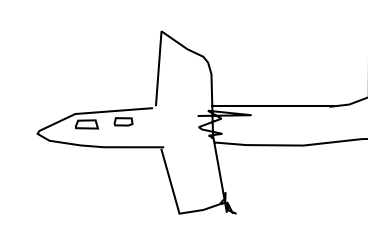

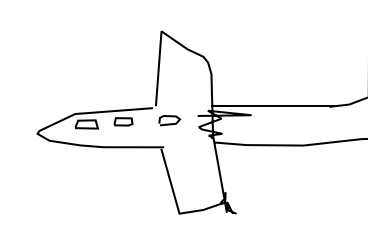

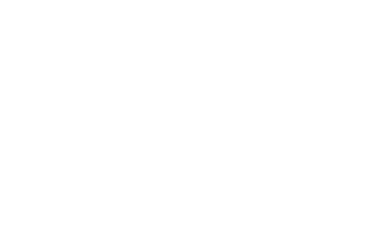

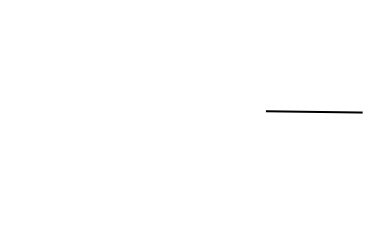

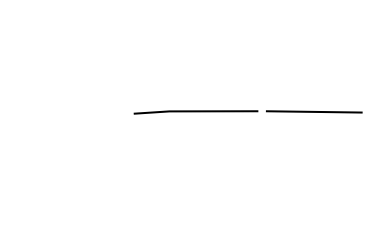

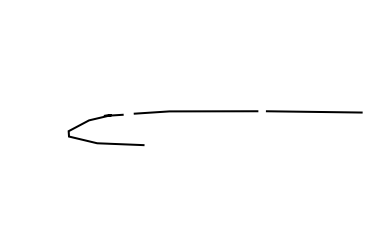

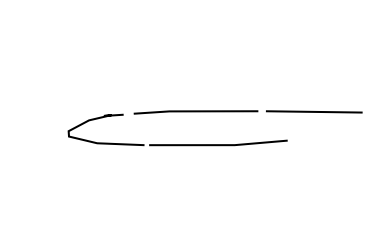

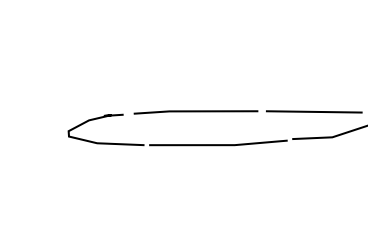

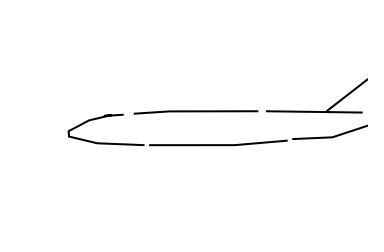

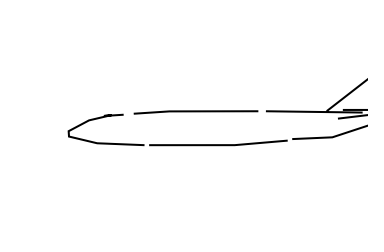

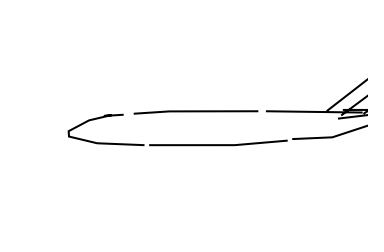

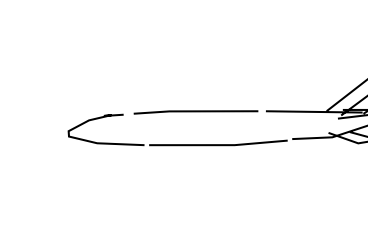

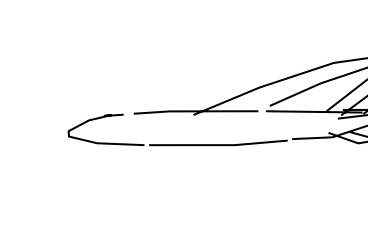

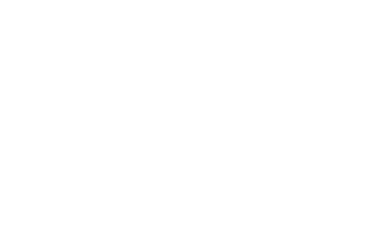

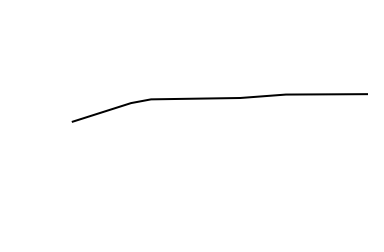

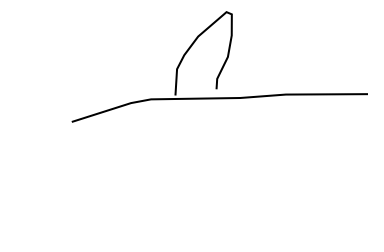

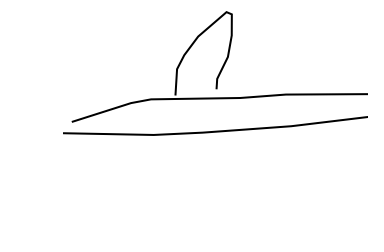

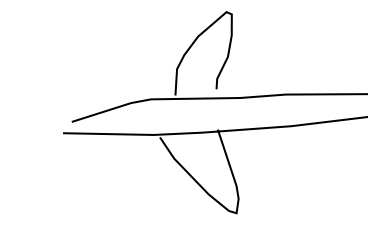

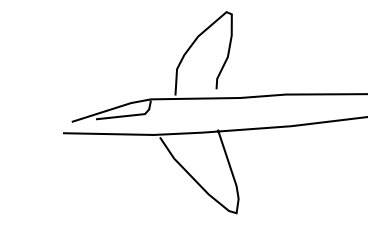

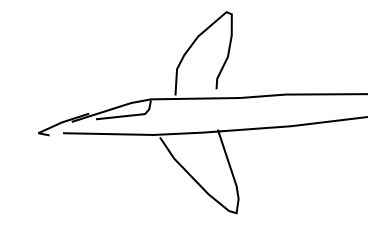

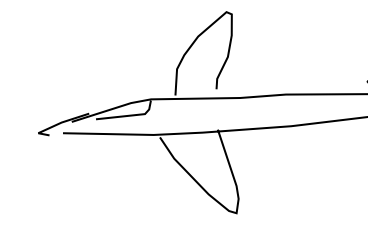

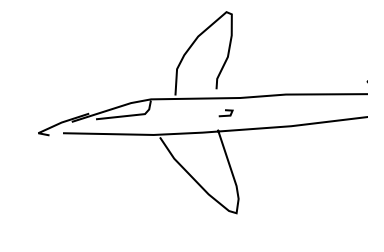

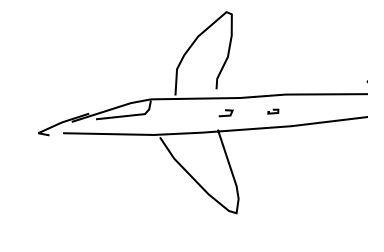

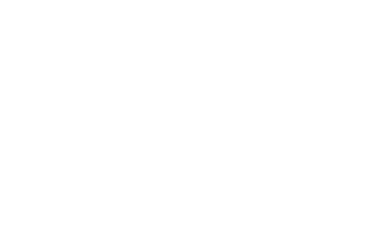

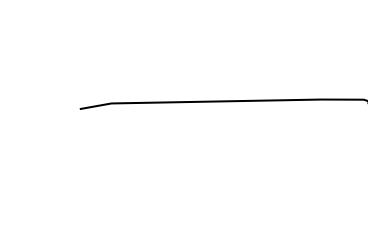

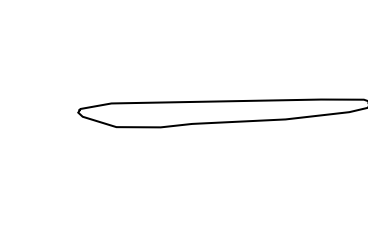

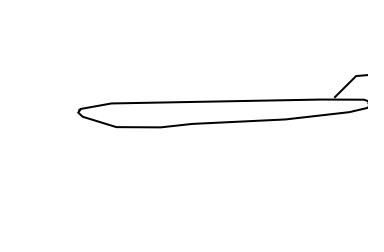

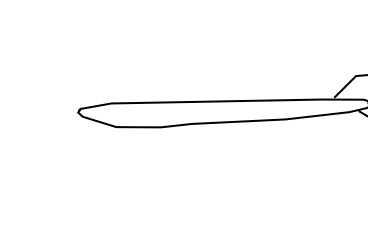

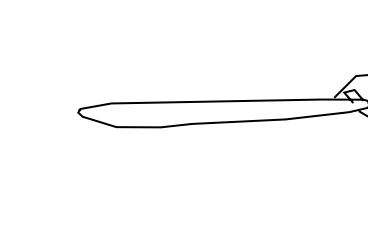

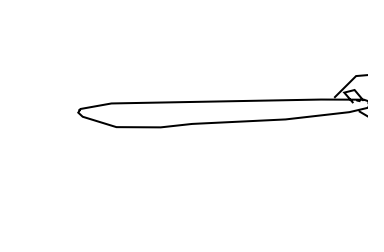

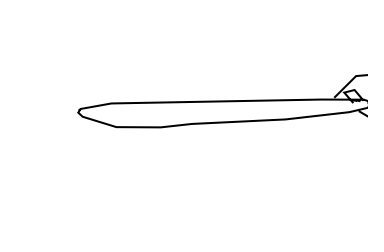

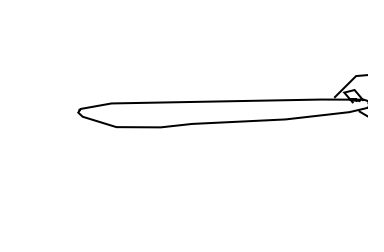

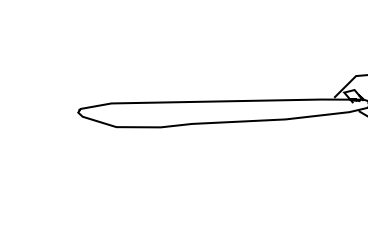

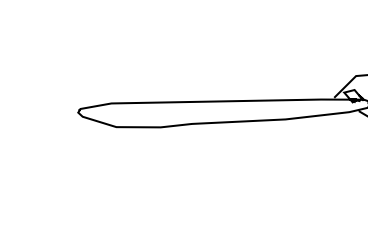

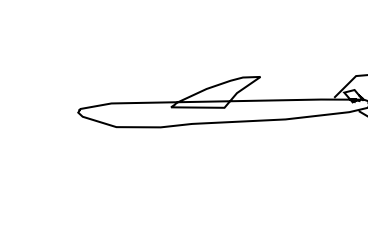

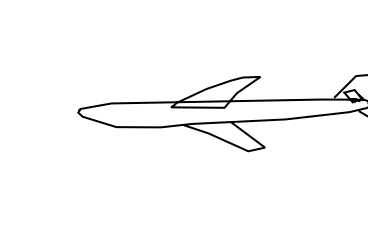

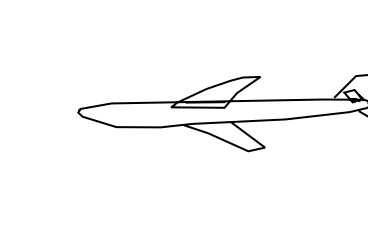

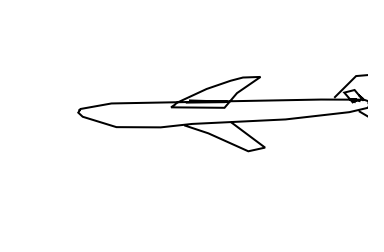

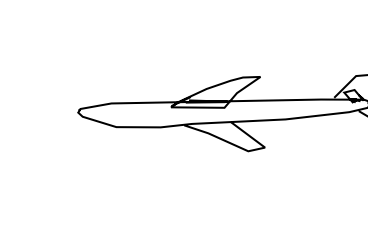

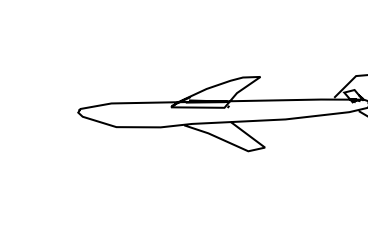

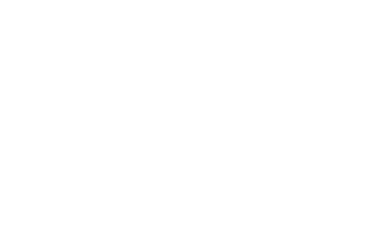

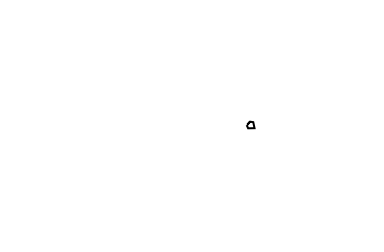

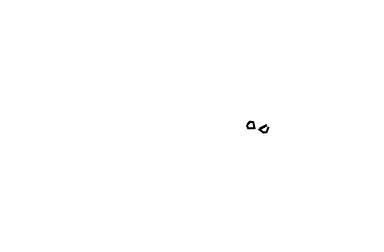

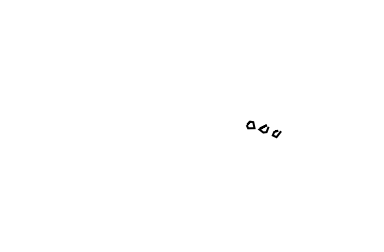

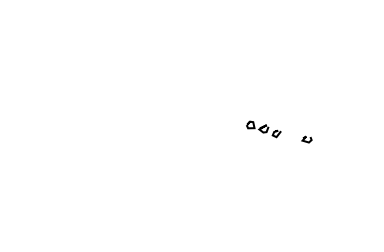

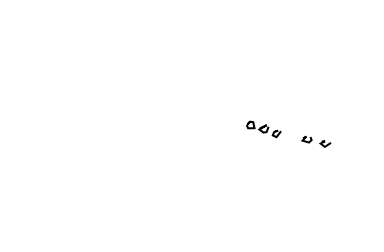

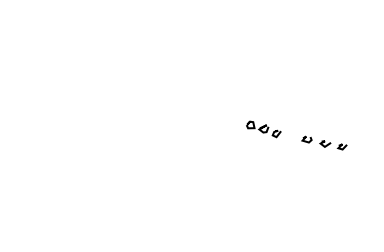

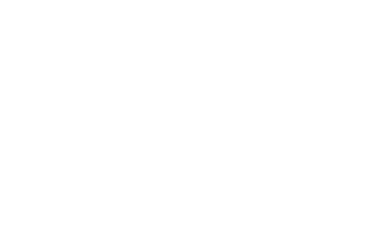

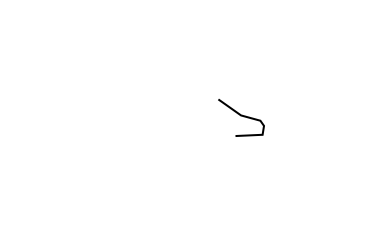

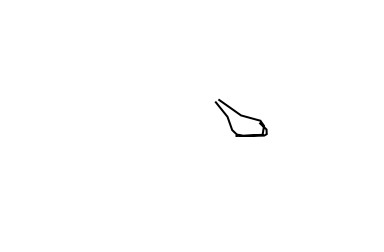

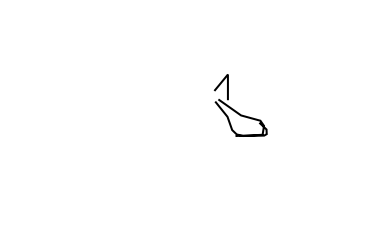

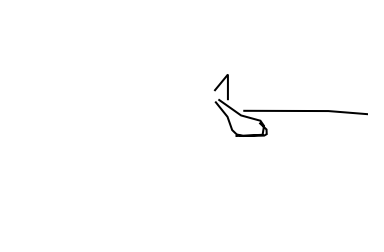

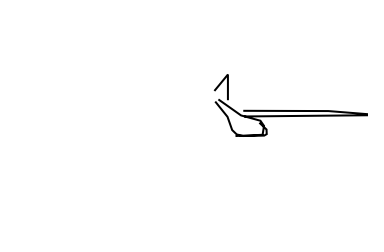

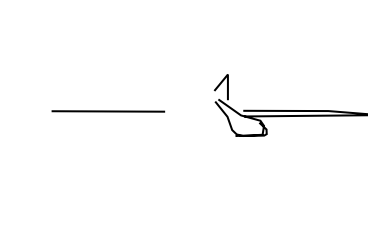

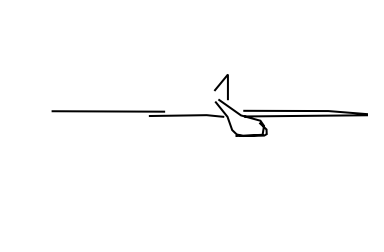

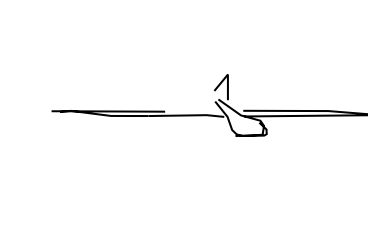

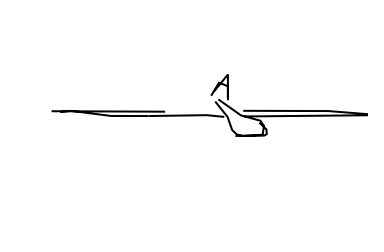

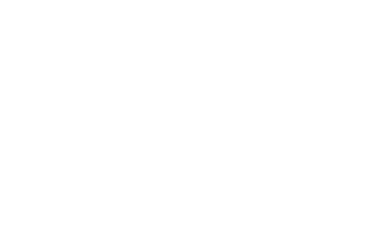

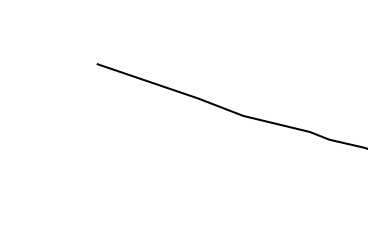

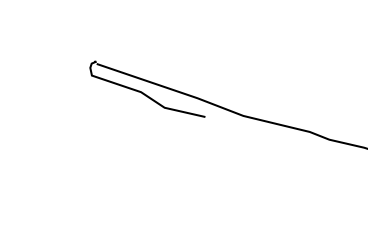

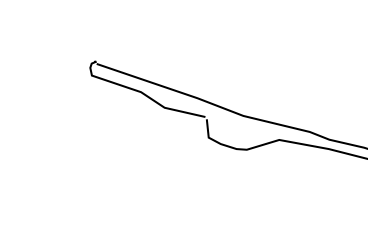

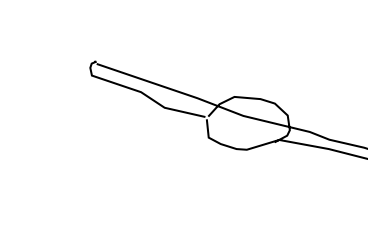

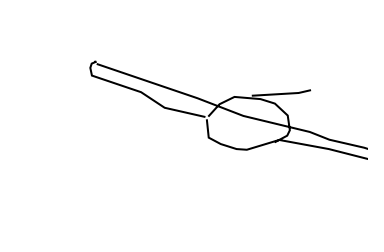

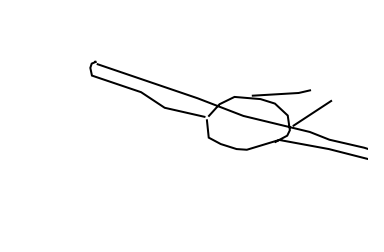

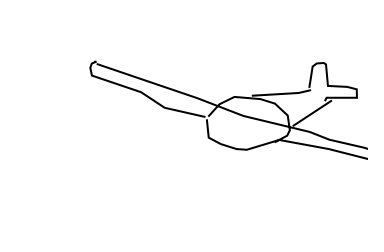

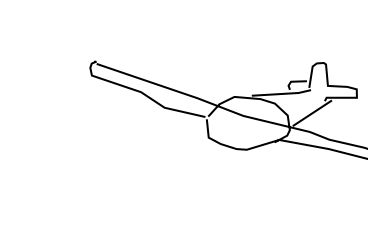

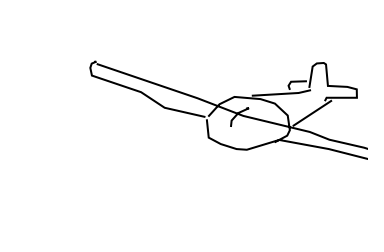

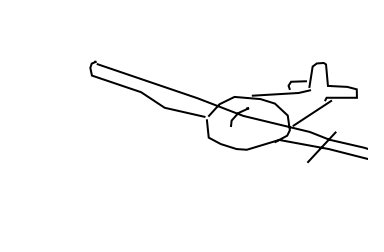

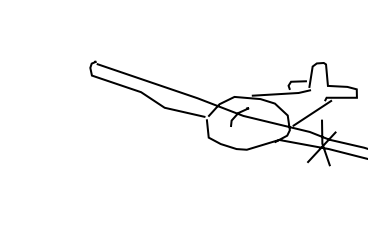

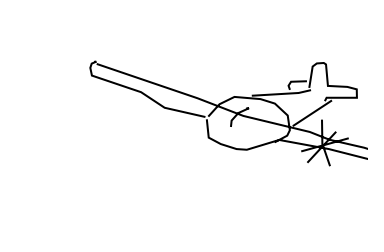

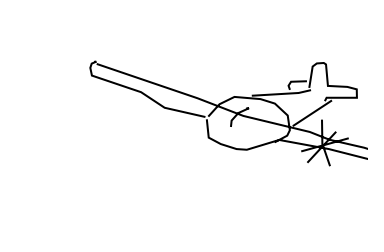

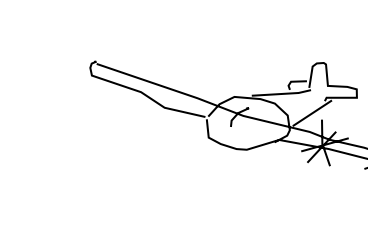

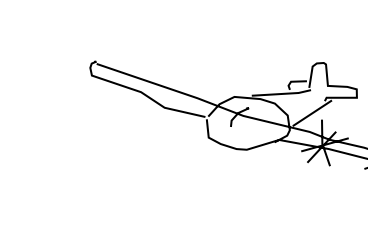

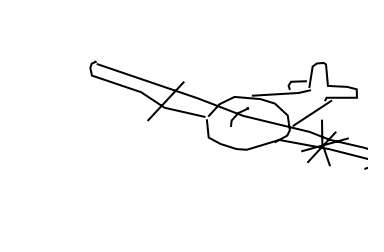

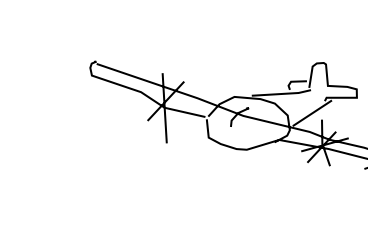

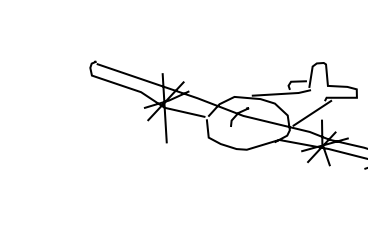

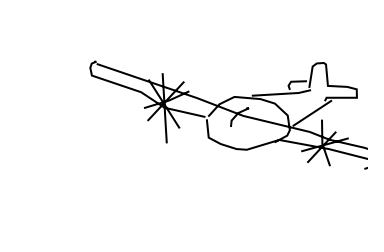

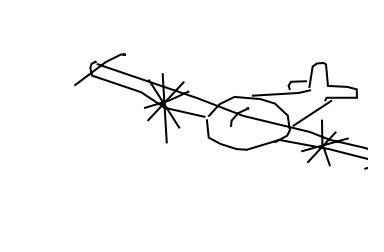

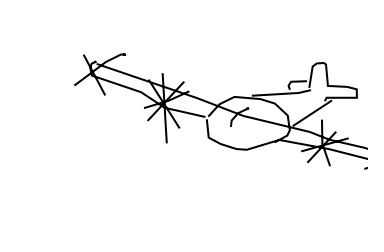

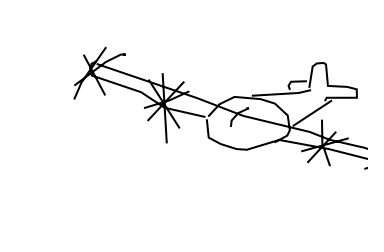

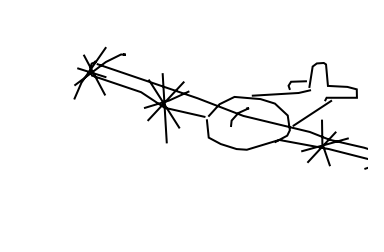

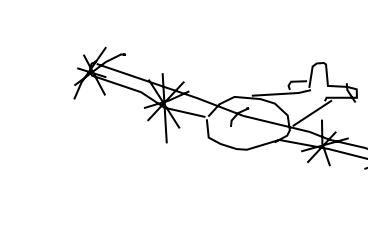

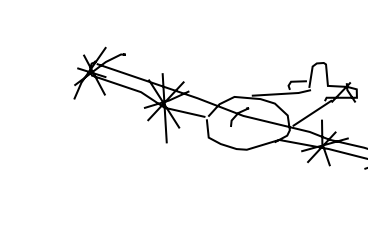

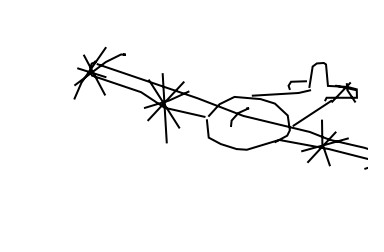

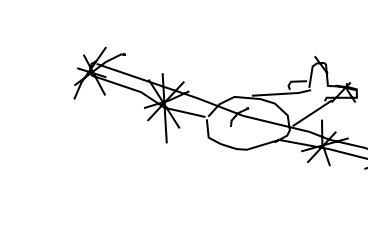

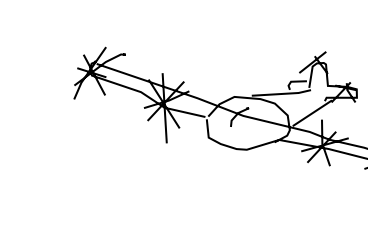

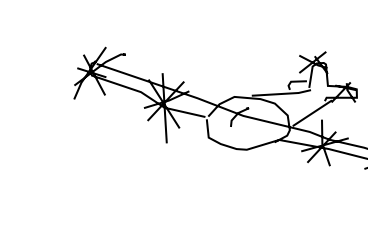

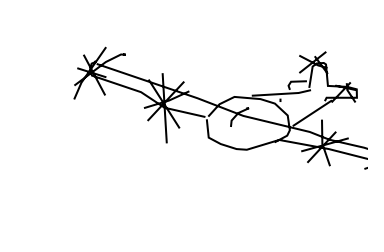

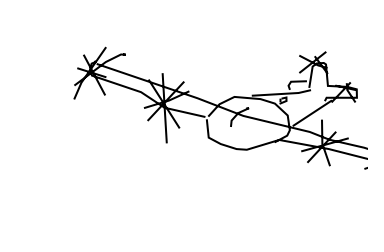

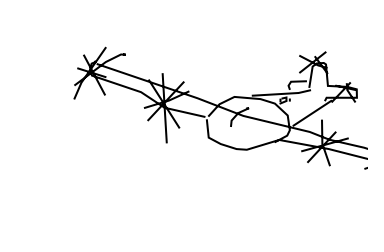

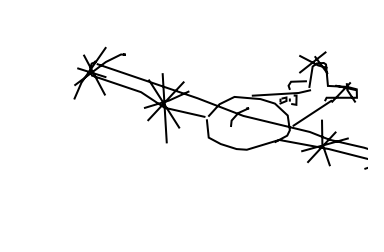

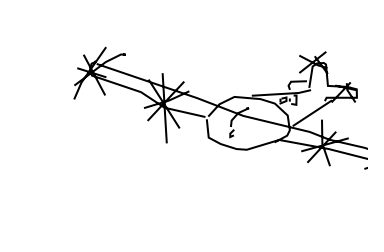

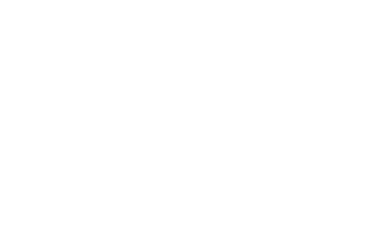

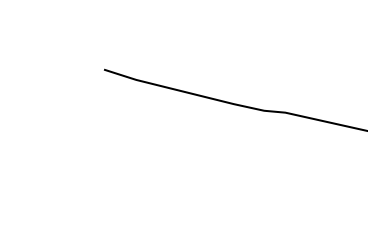

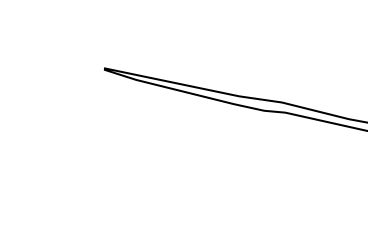

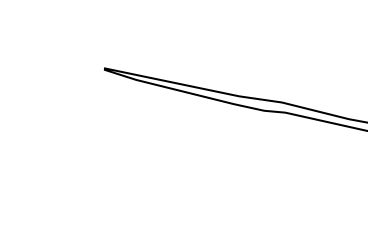

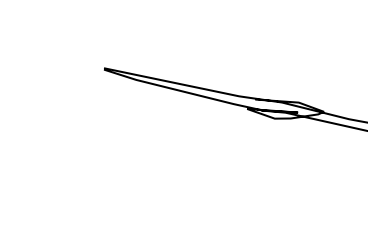

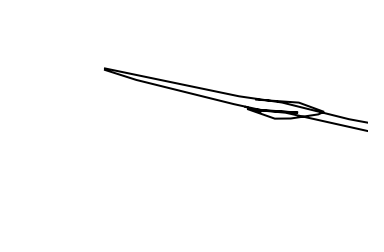

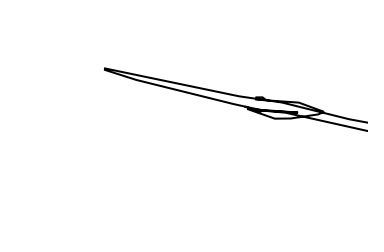

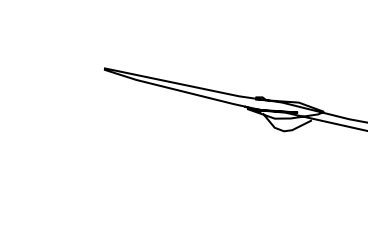

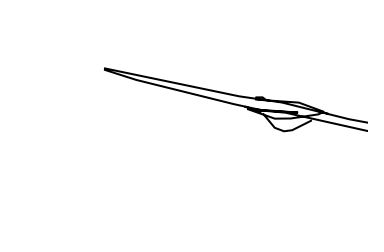

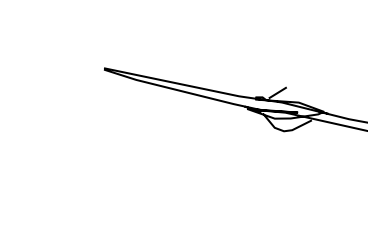

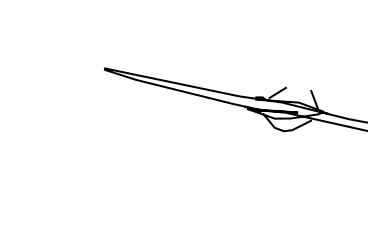

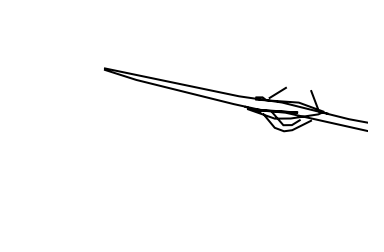

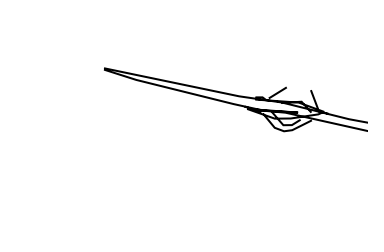

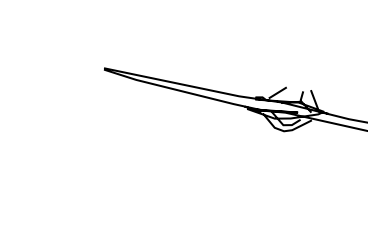

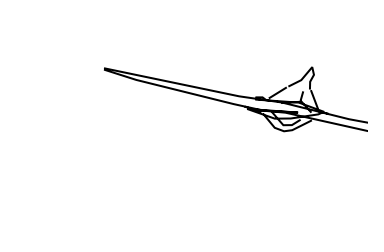

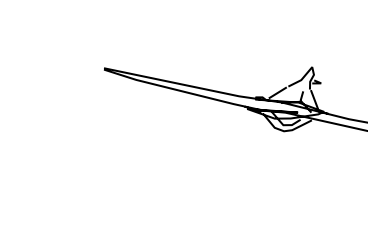

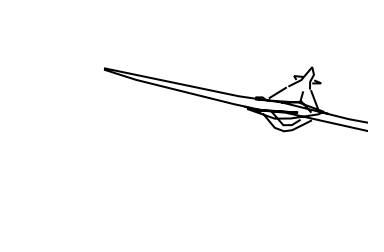

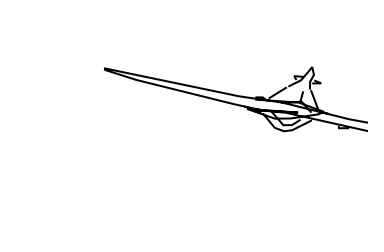

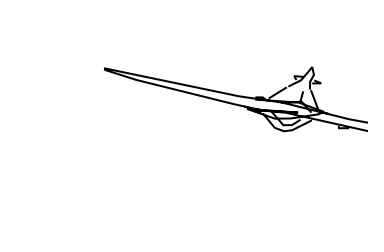

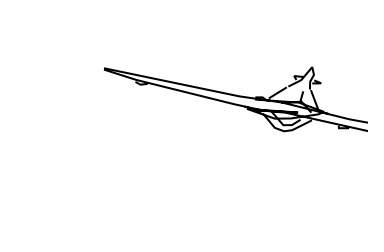

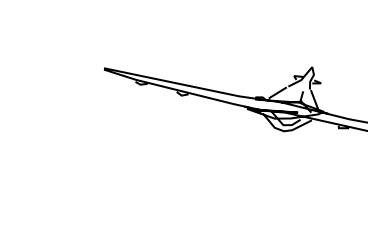

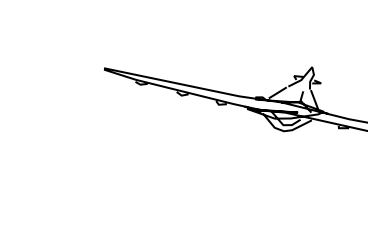

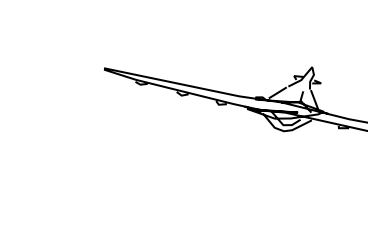

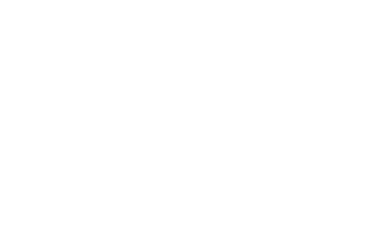

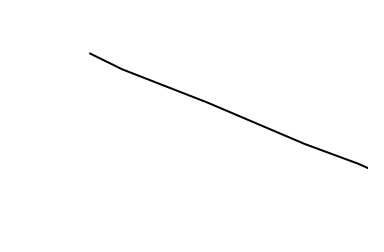

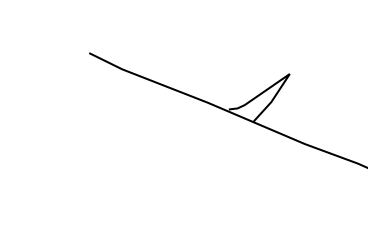

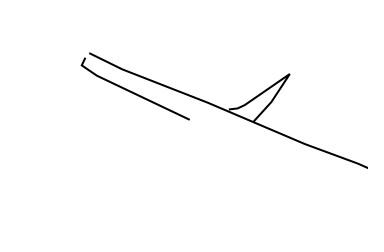

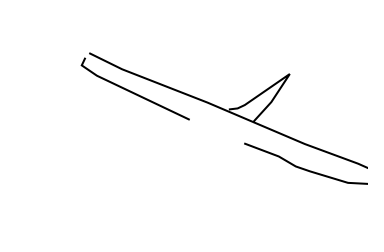

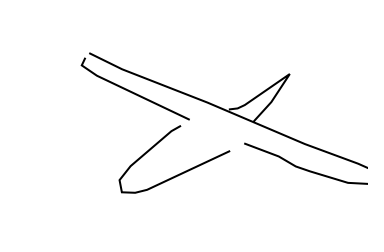

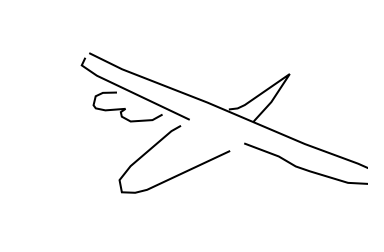

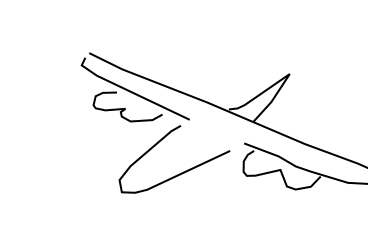

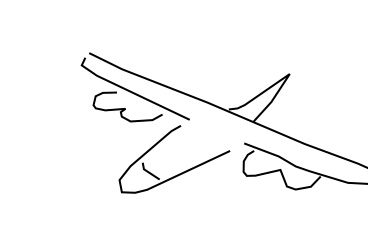

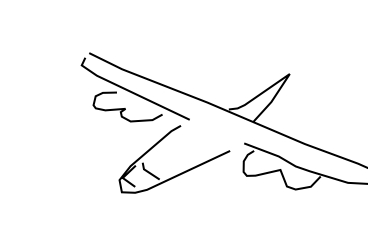

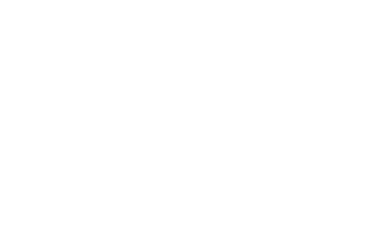

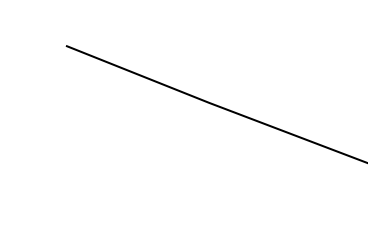

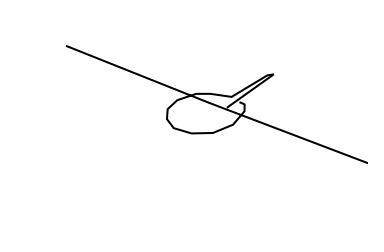

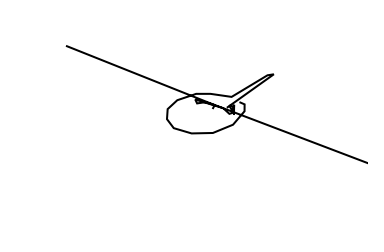

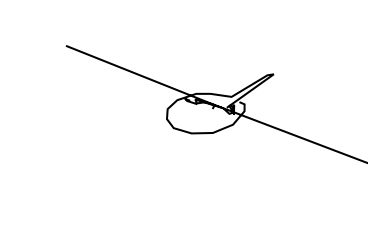

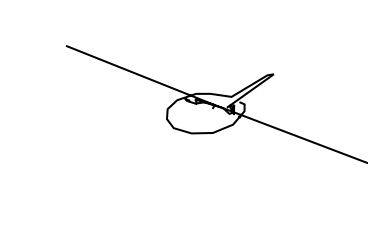

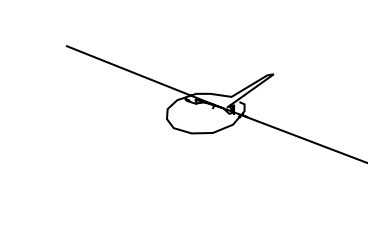

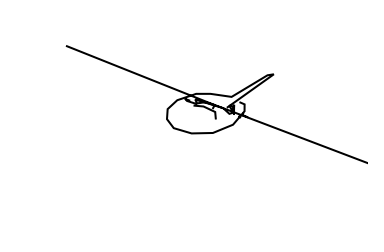

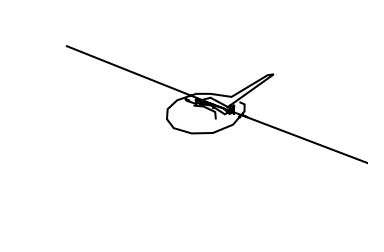

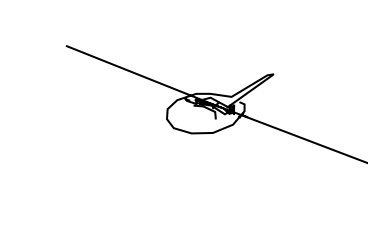

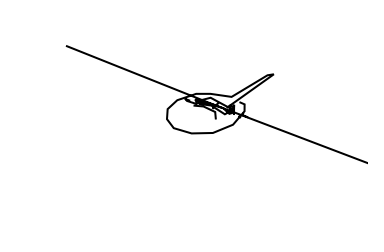

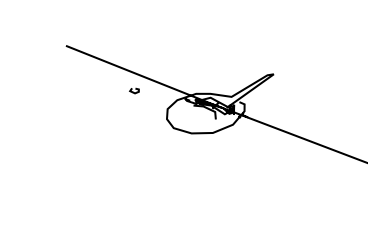

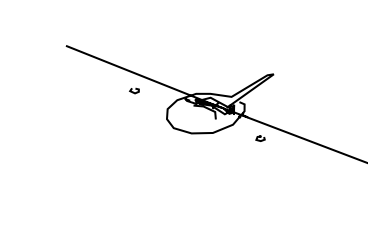

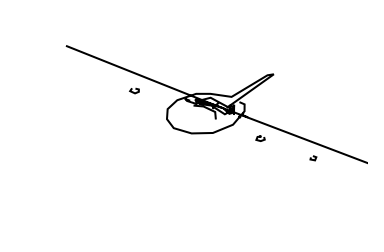

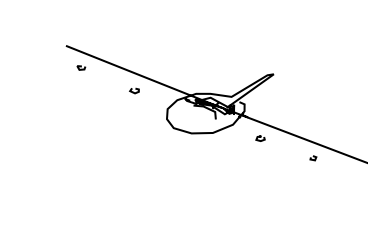

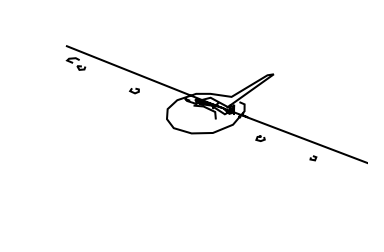

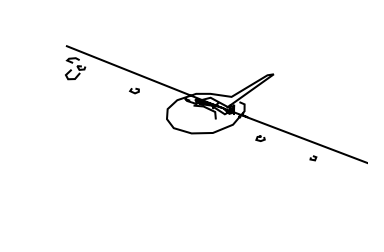

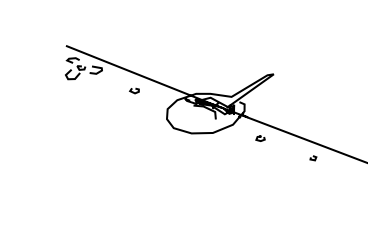

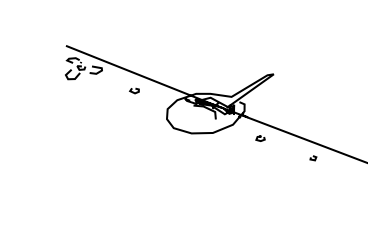

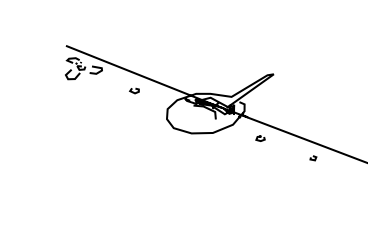

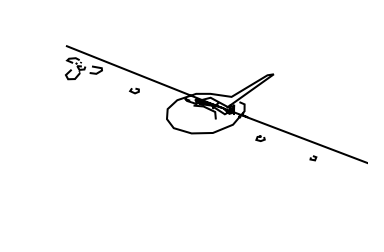

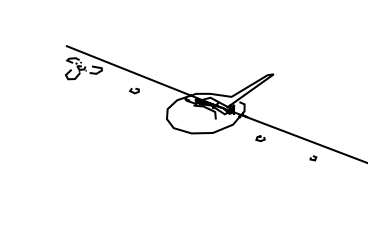

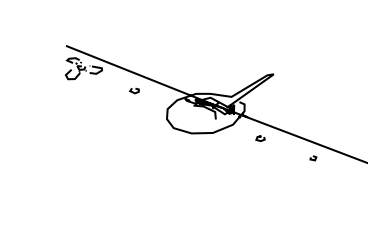

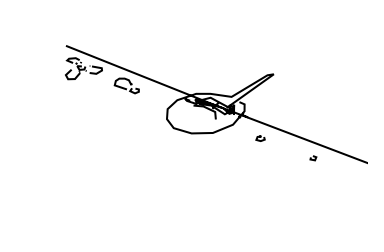

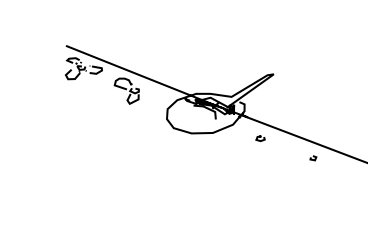

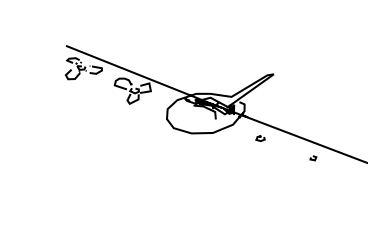

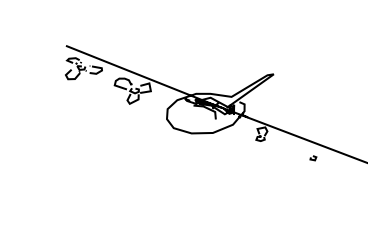

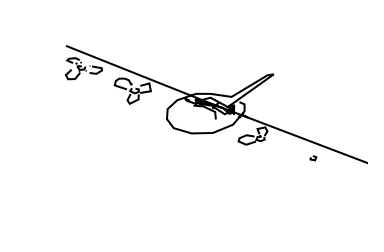

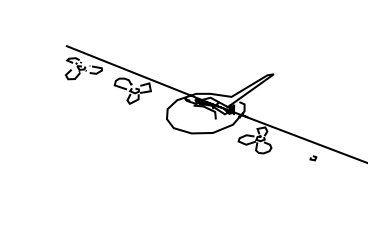

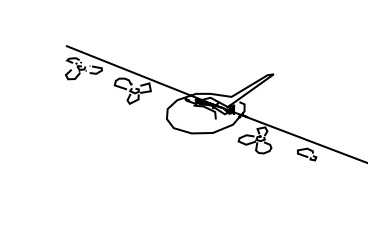

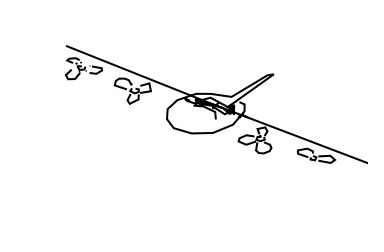

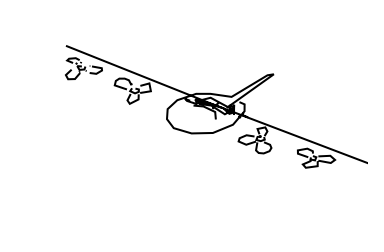

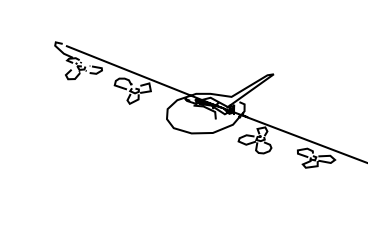

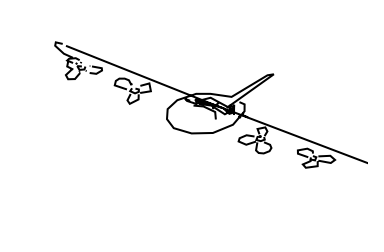

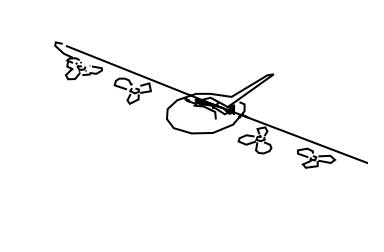

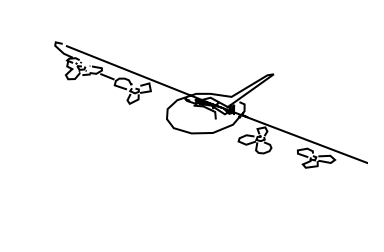

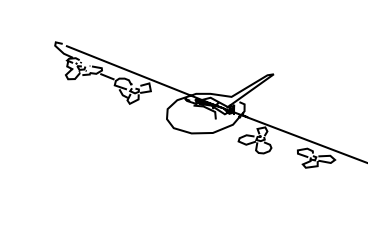

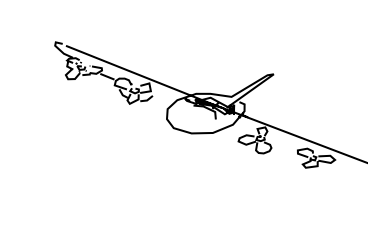

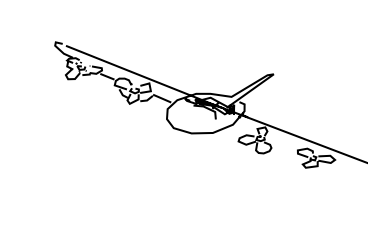

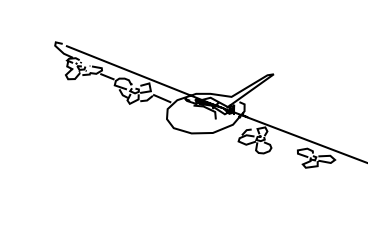

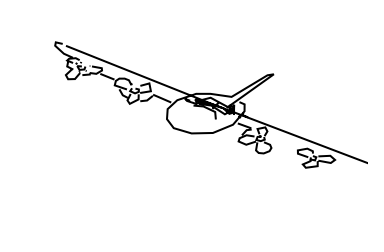

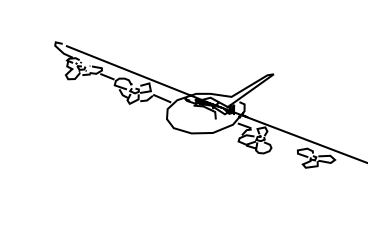

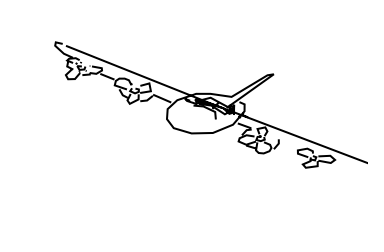

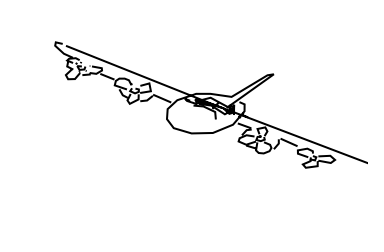

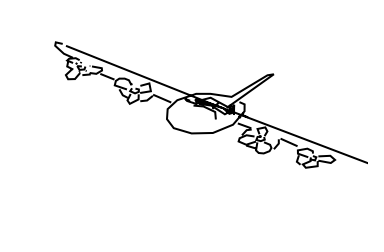

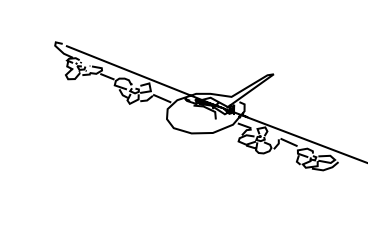

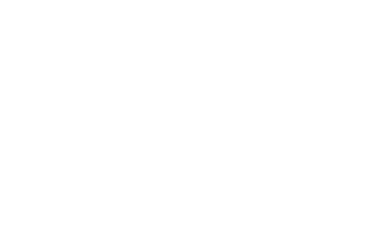

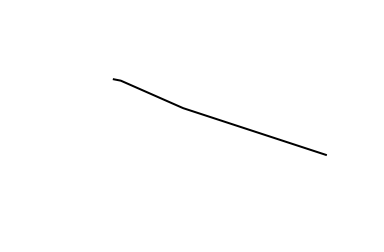

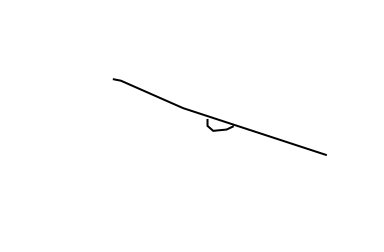

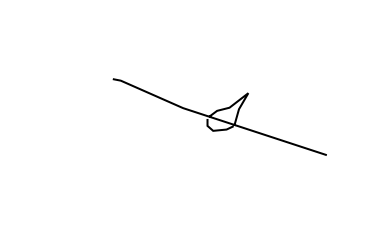

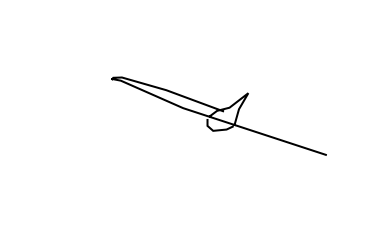

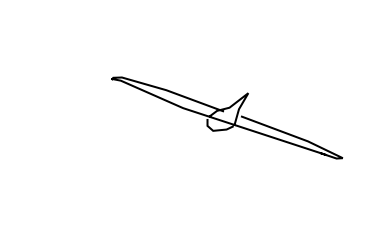

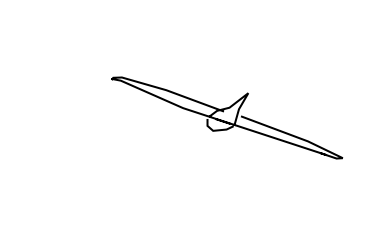

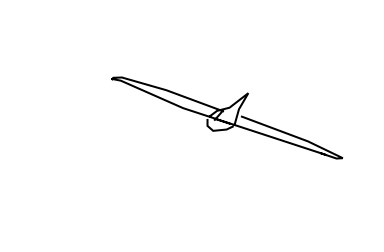

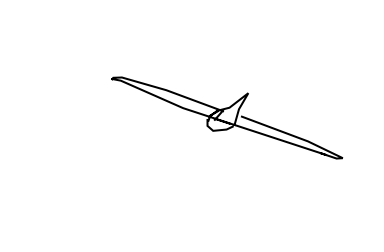

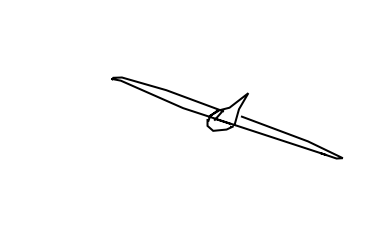

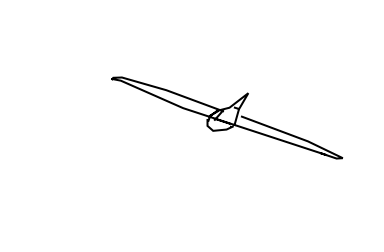

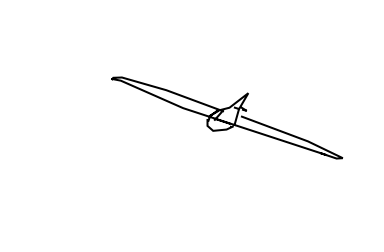

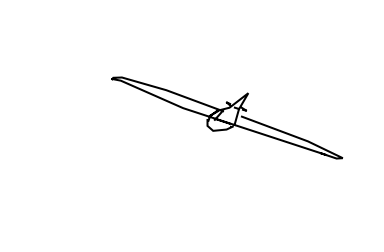

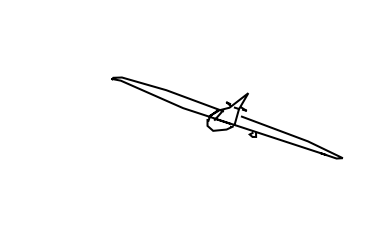

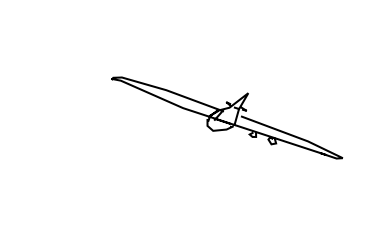

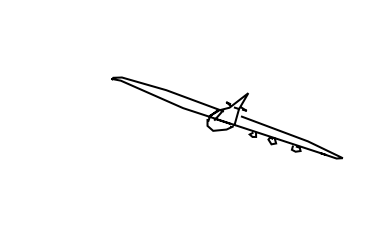

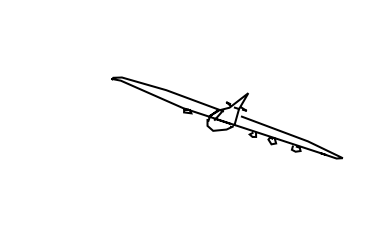

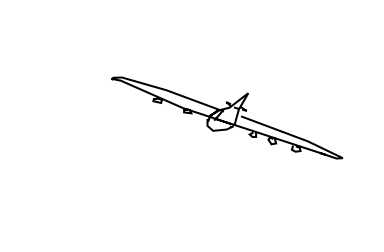

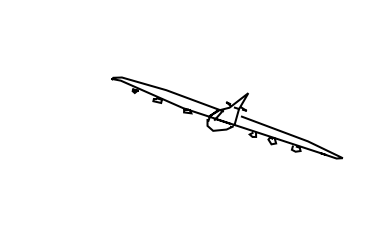

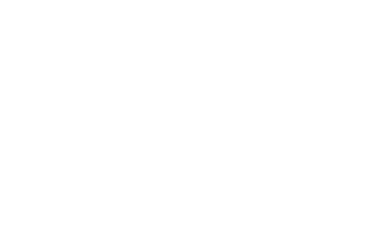

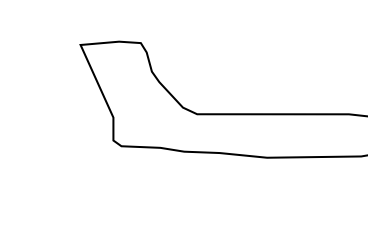

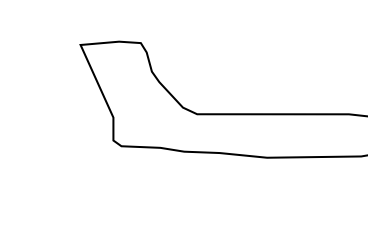

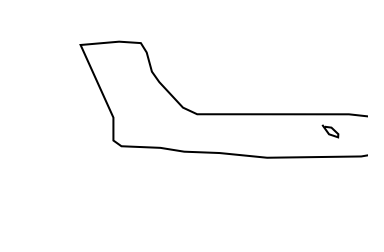

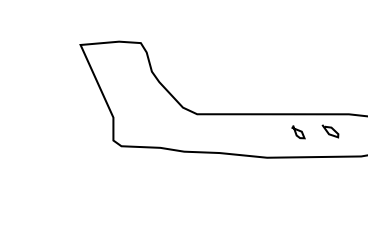

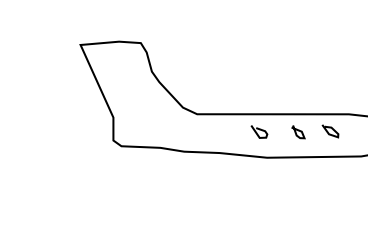

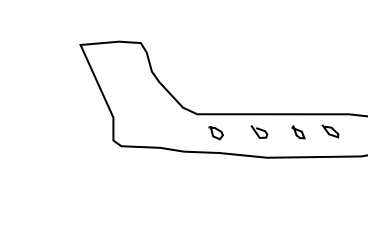

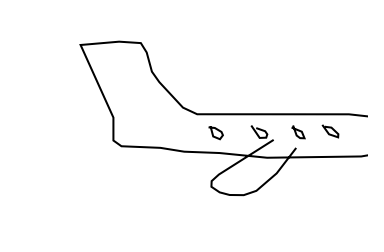

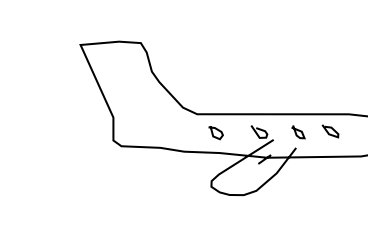

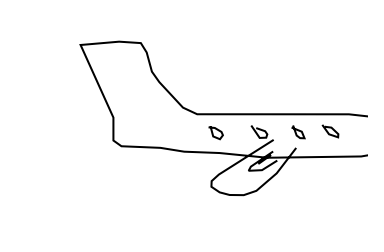

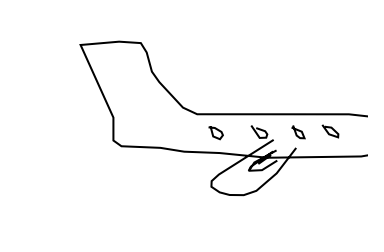

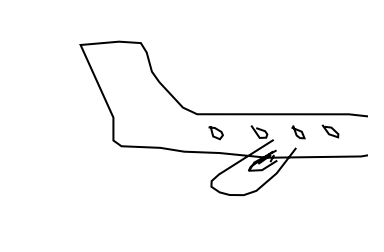

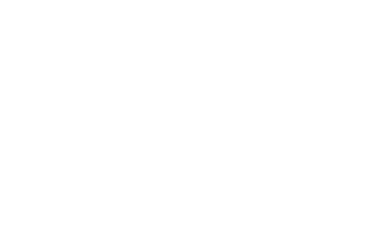

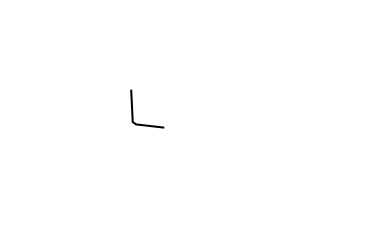

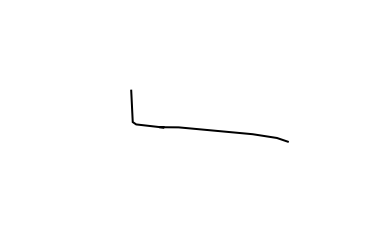

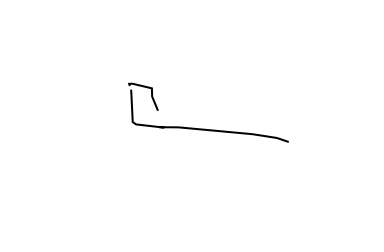

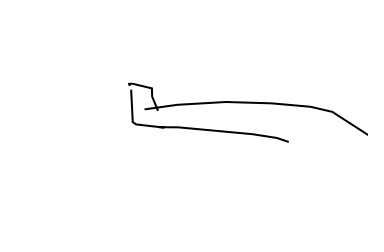

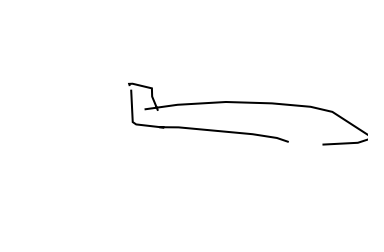

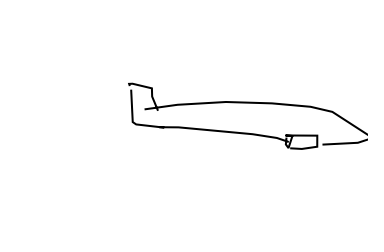

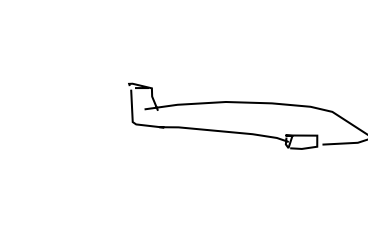

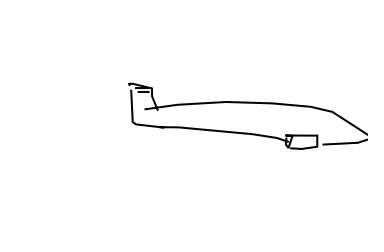

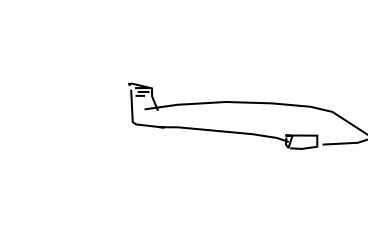

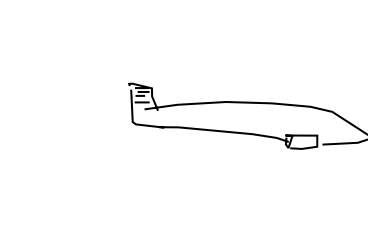

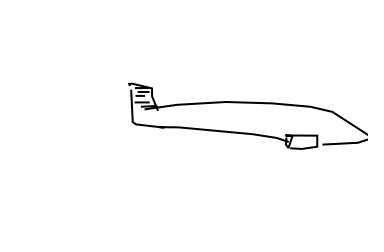

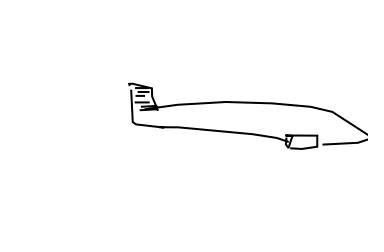

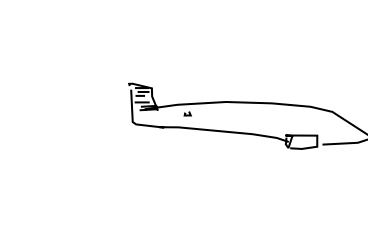

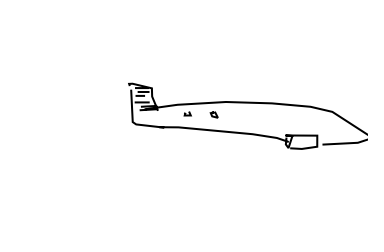

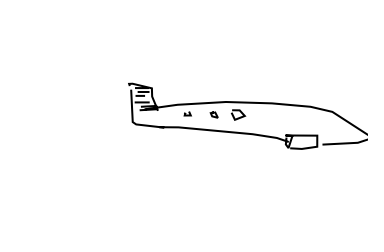

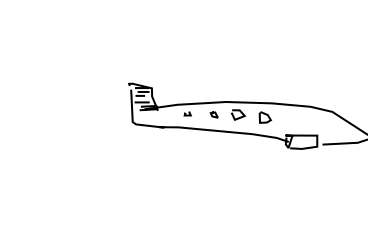

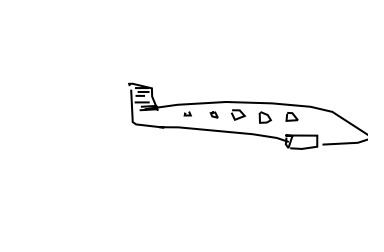

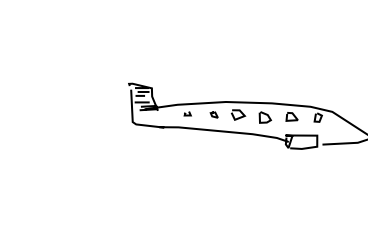

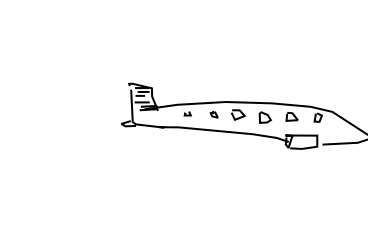

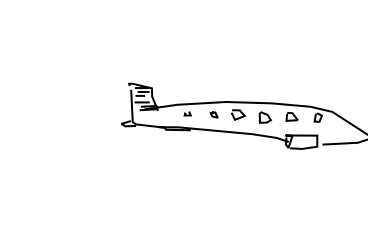

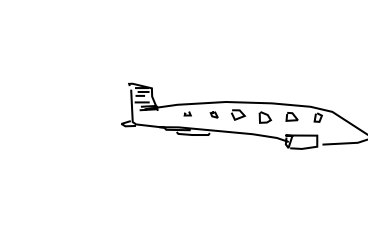

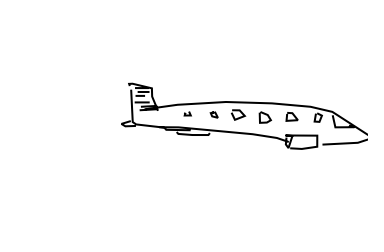

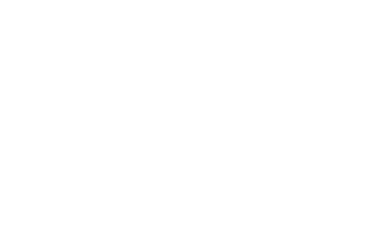

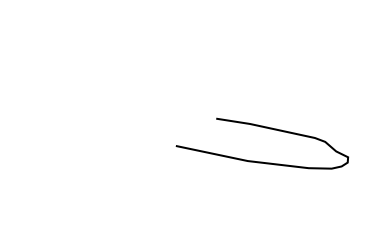

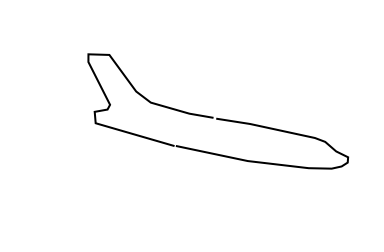

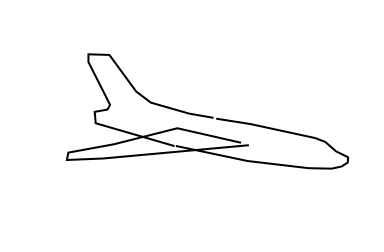

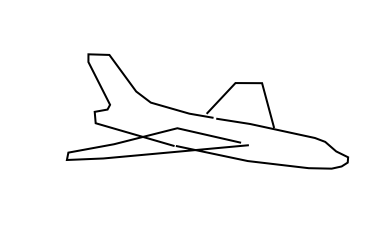

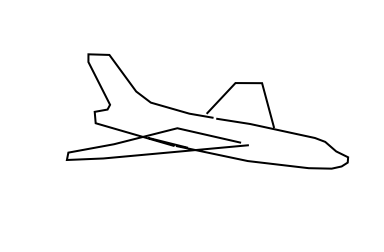

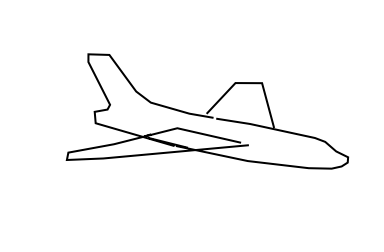

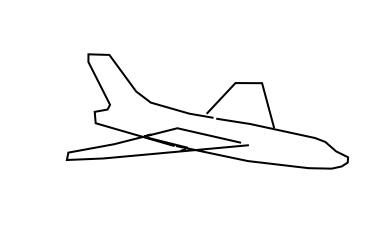

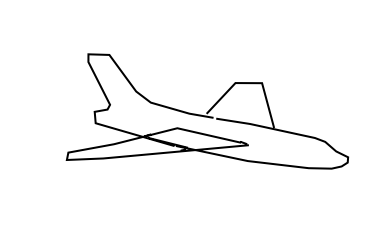

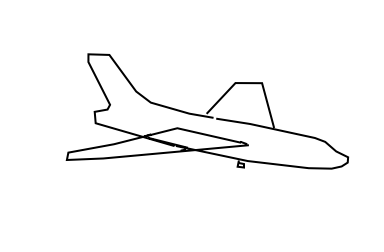

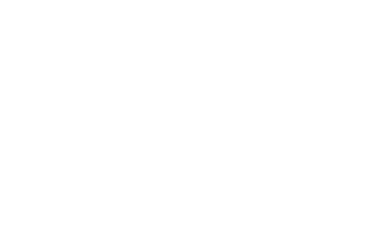

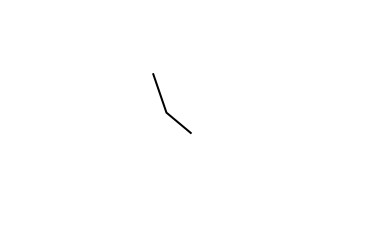

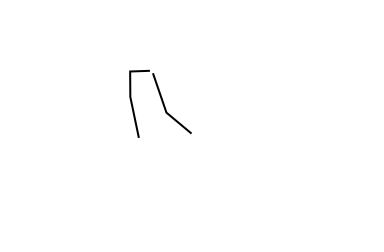

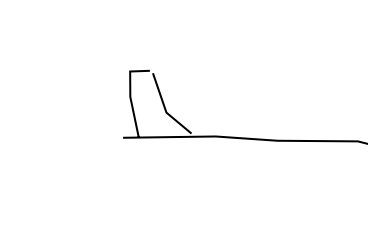

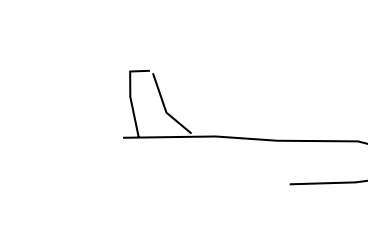

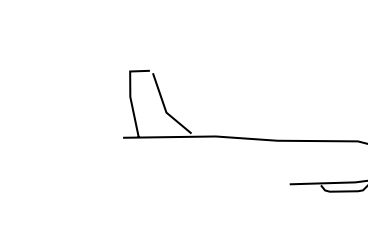

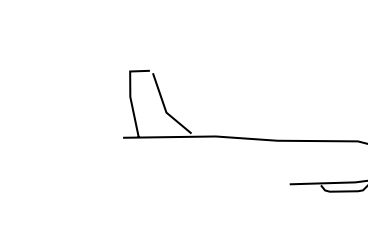

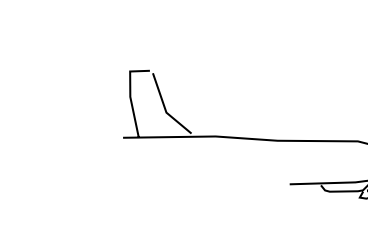

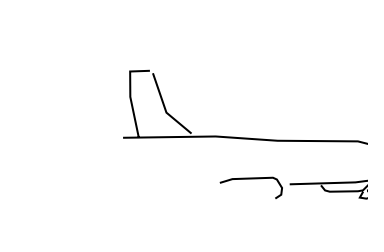

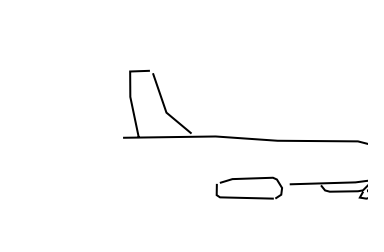

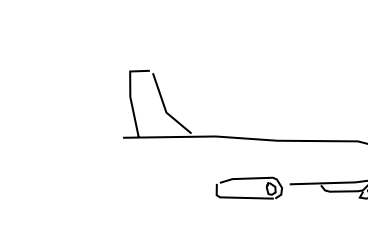

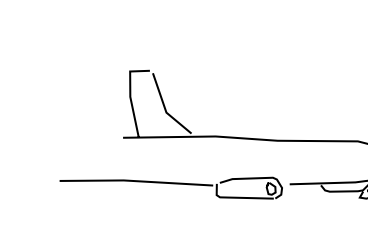

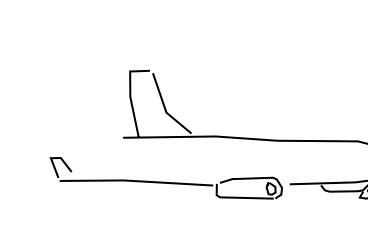

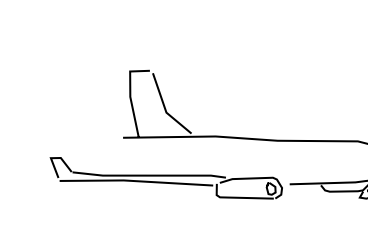

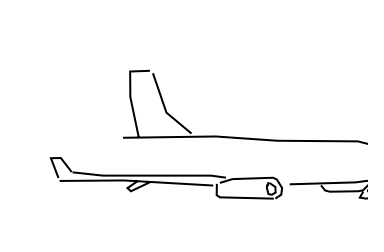

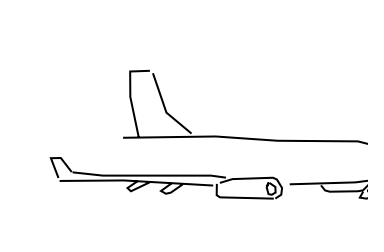

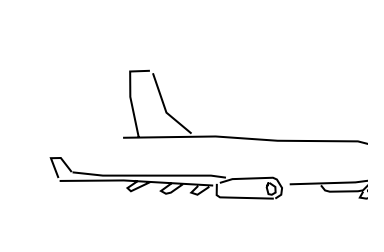

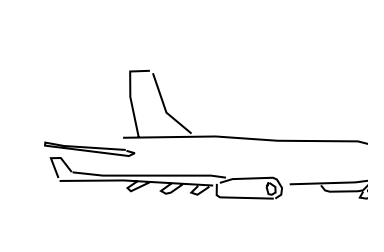

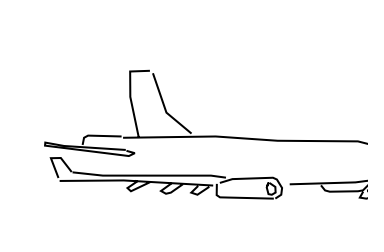

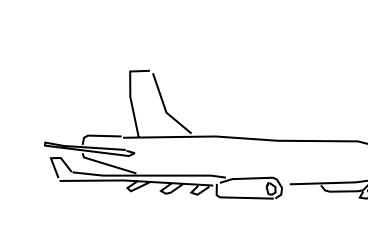

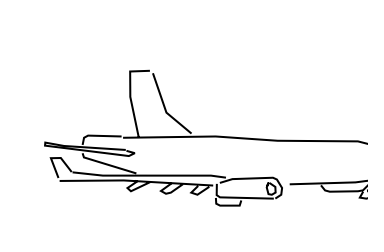

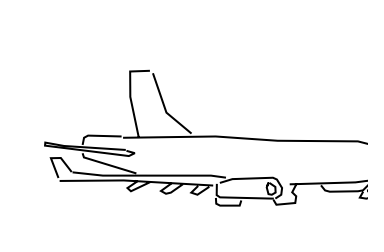

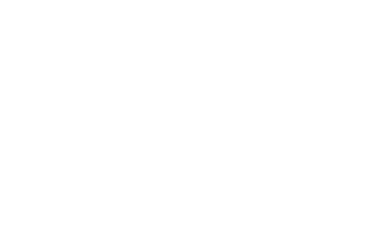

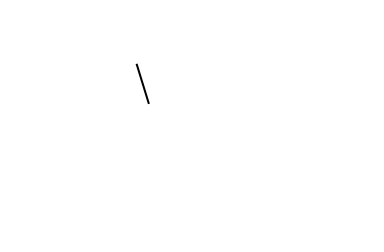

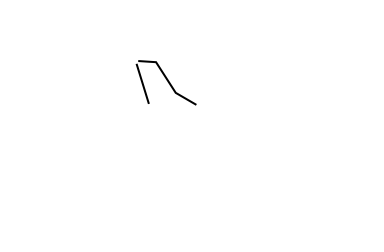

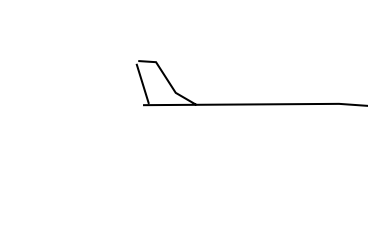

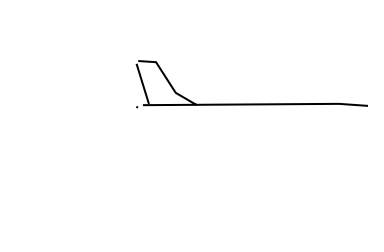

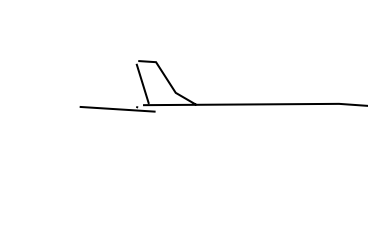

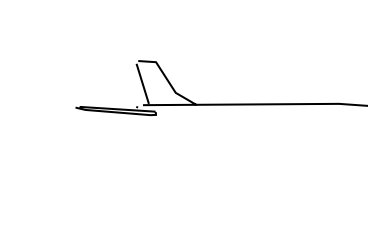

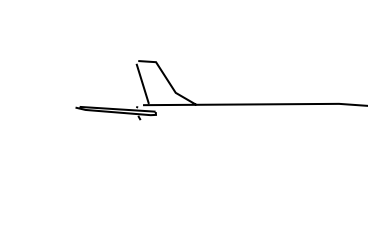

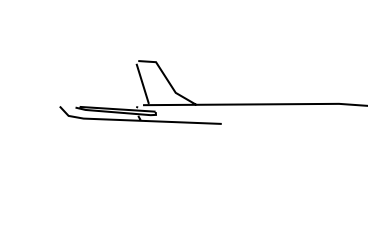

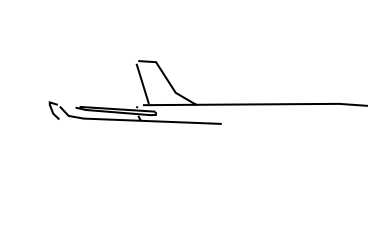

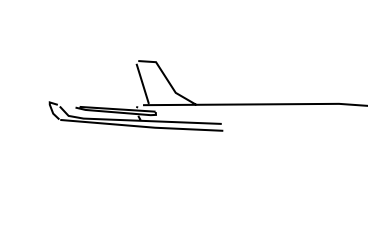

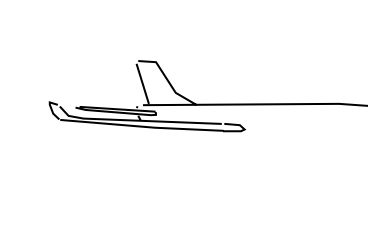

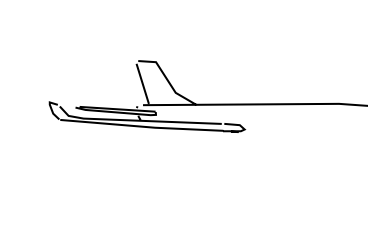

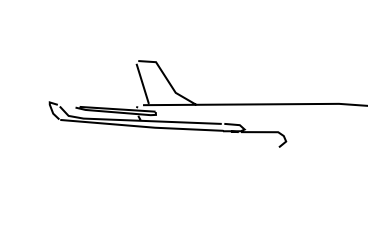

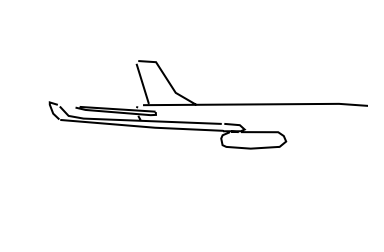

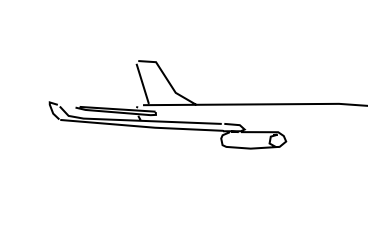

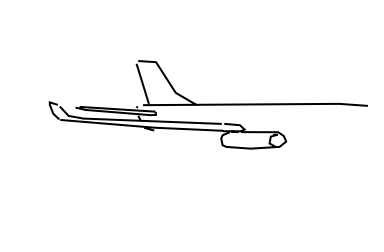

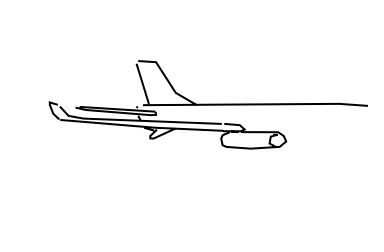

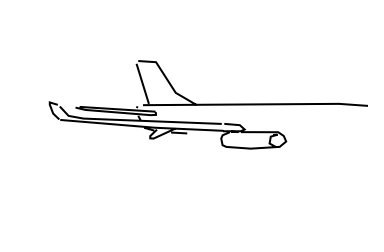

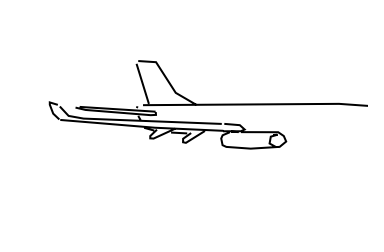

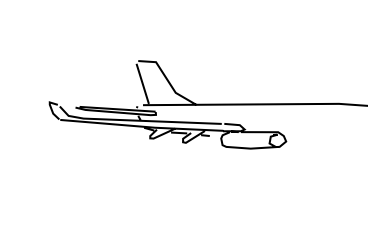

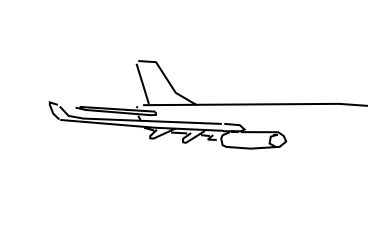

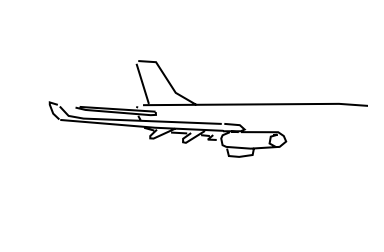

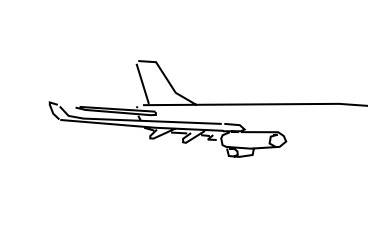

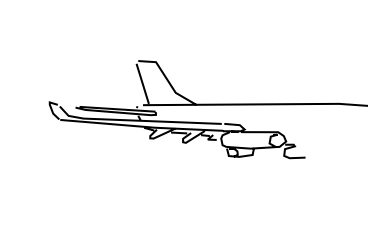

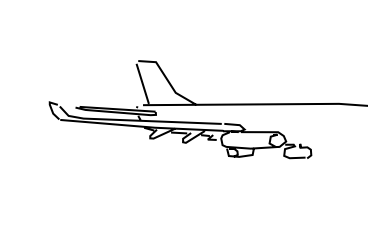

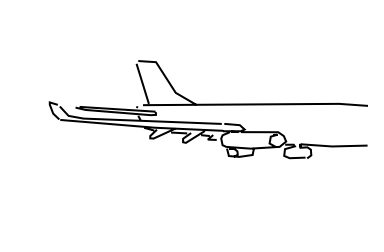

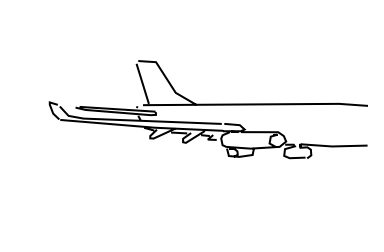

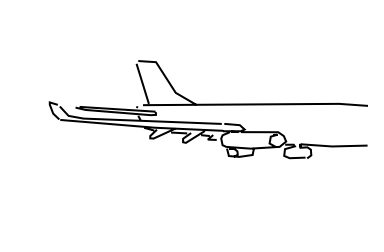

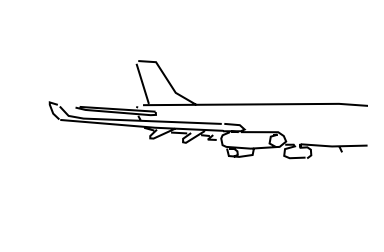

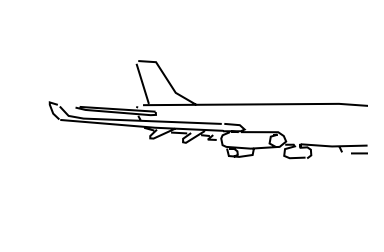

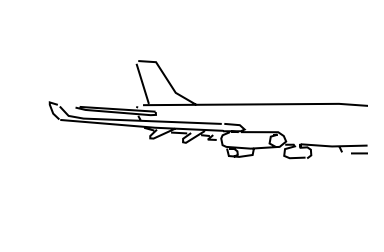

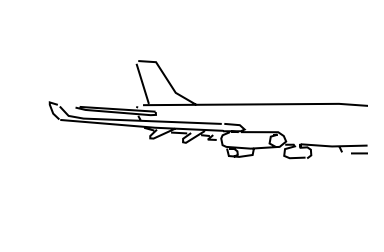

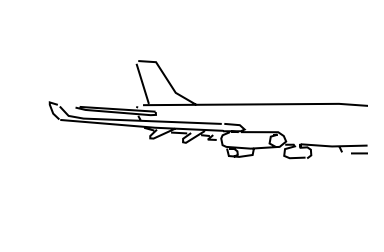

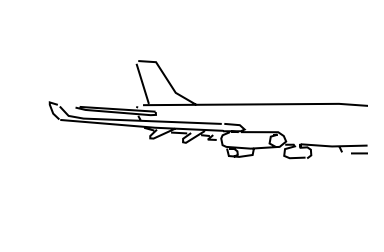

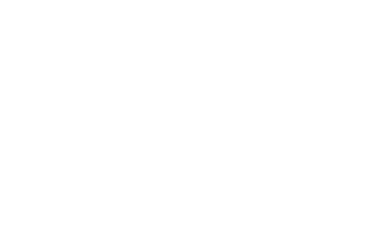

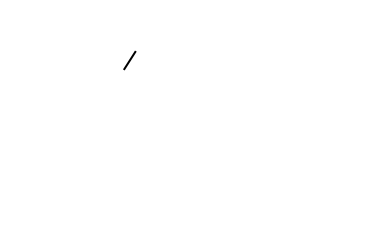

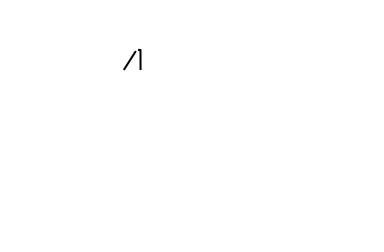

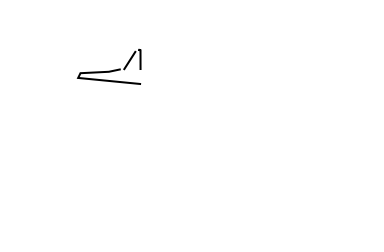

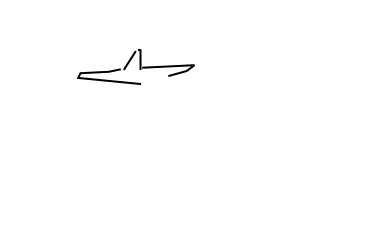

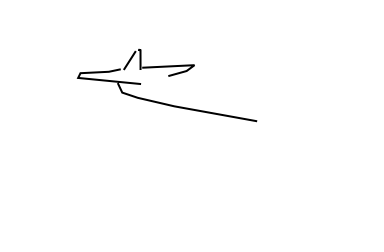

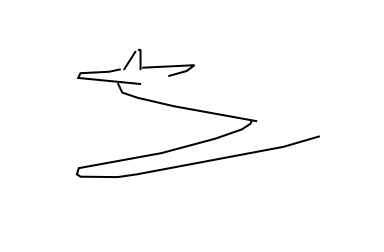

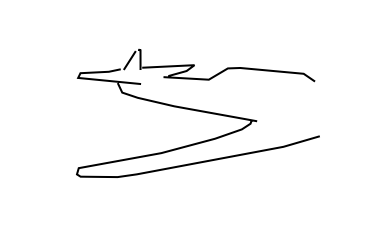

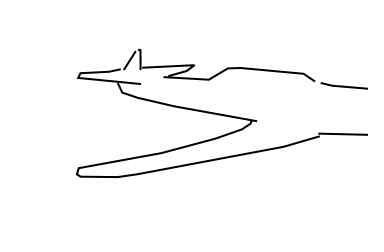

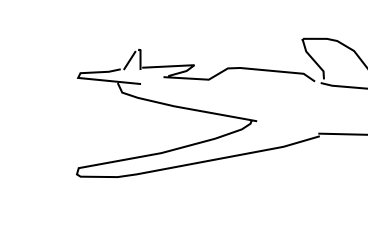

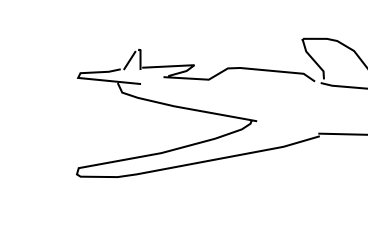

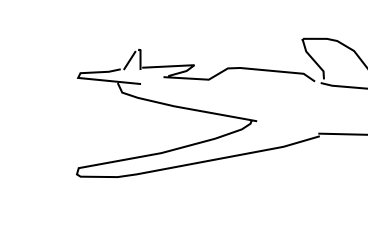

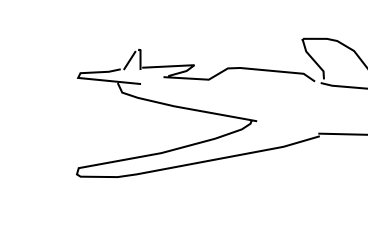

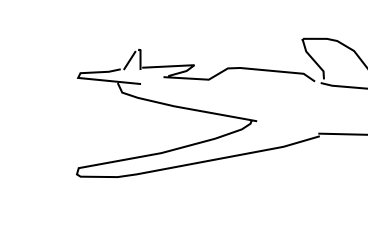

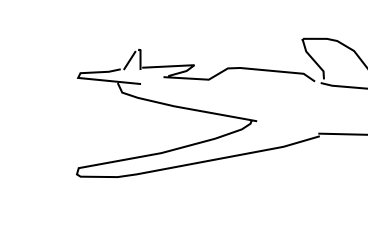

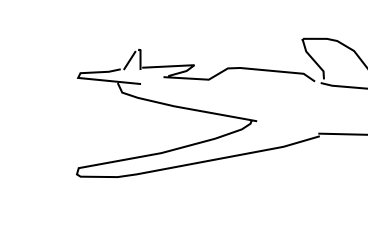

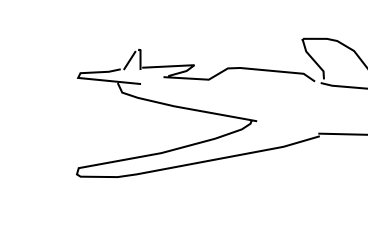

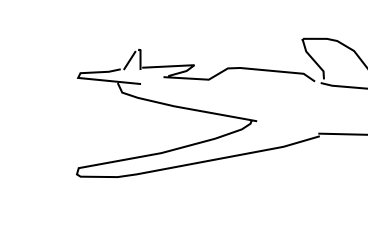

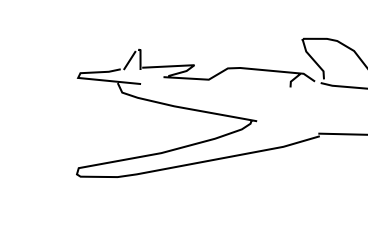

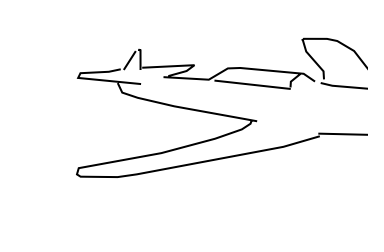

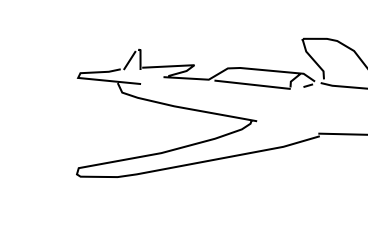

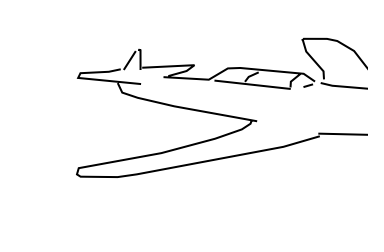

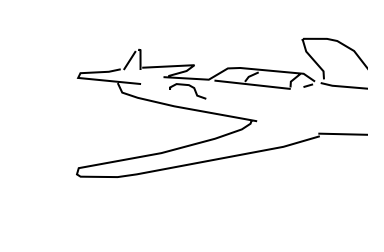

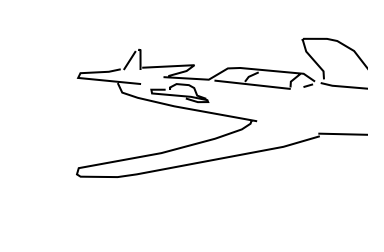

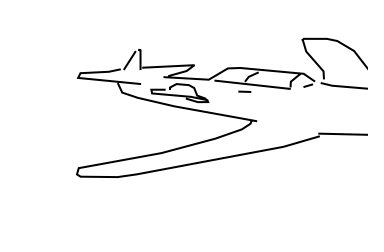

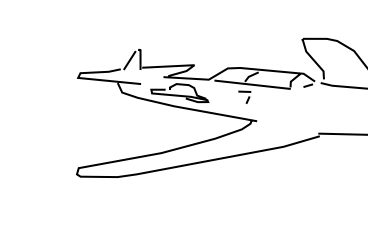

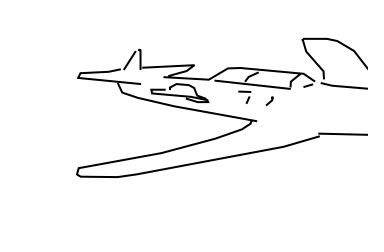

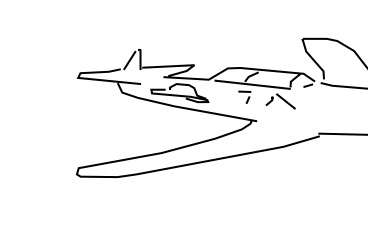

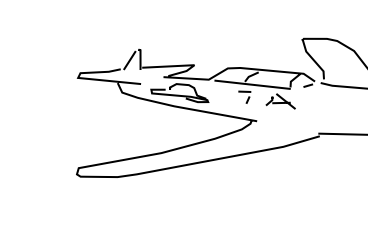

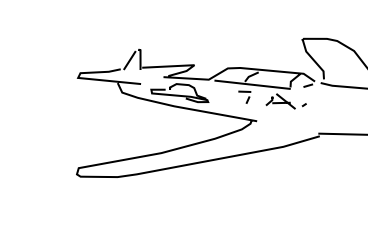

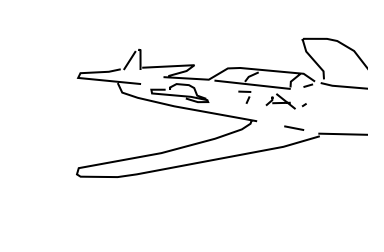

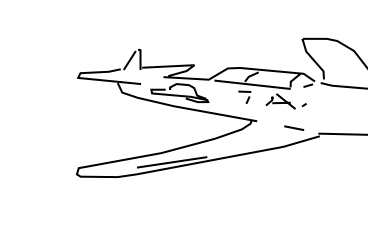

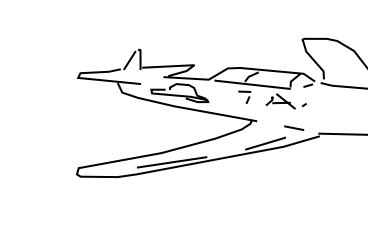

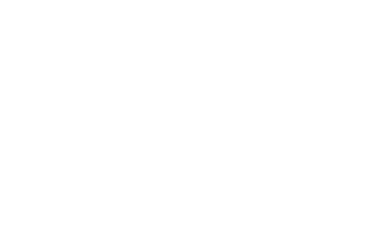

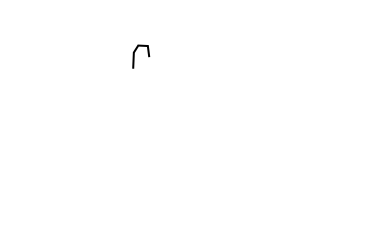

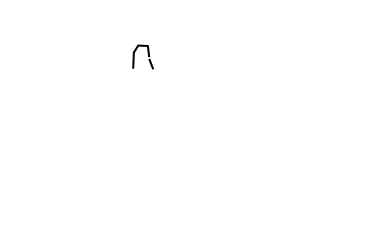

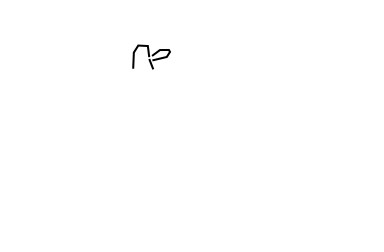

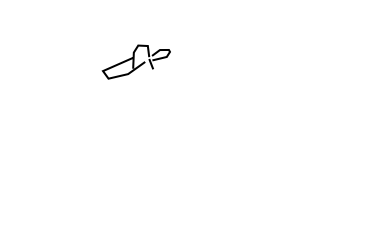

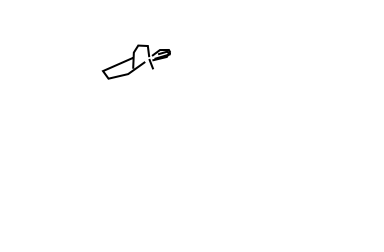

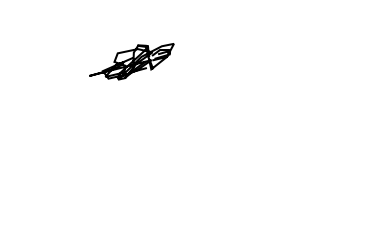

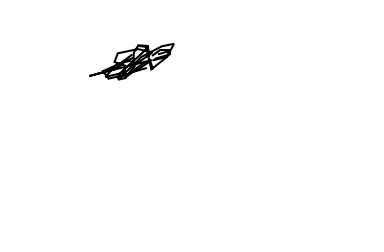

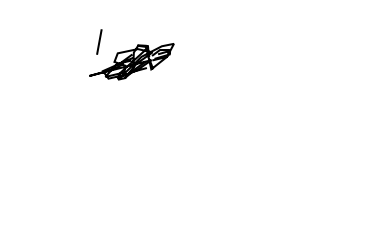

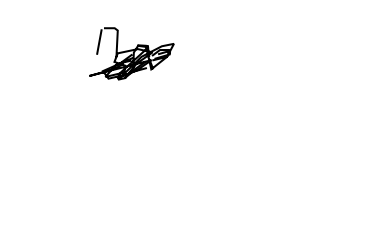

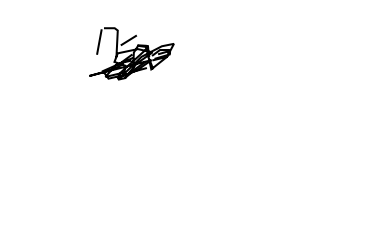

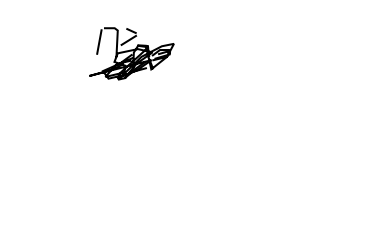

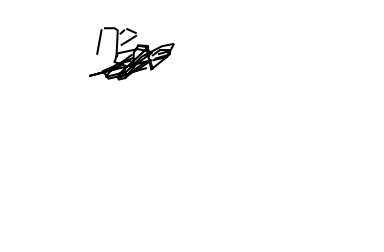

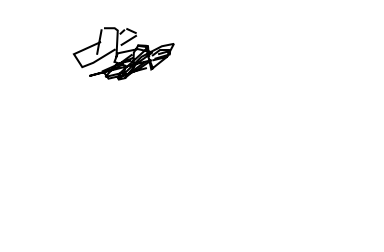

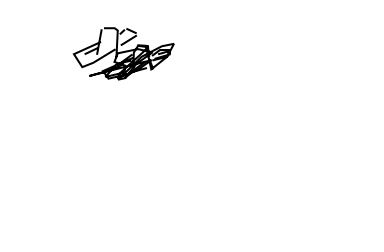

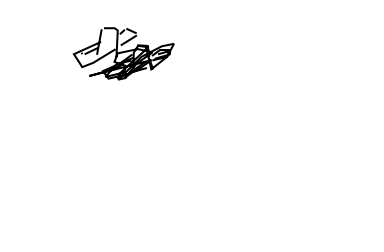

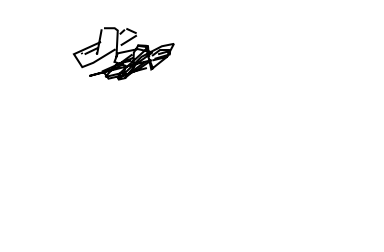

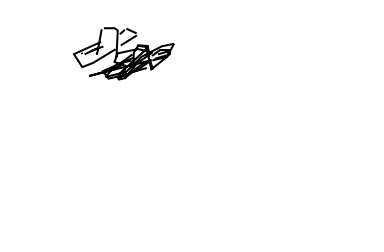

In [ ]:
for idx in range(len(airplanes)):
    sample = airplanes[idx]
    this_sketchID = zipped[idx][1]
    lines = strokes_to_lines(to_normal_strokes(sample['strokes']))
    for i,l in enumerate(lines):
        verts,codes = polyline_pathmaker(lines[:i])
        fig = plt.figure()    
        ax = plt.subplot(111)
        ax.axis('off')
        ax.set_xlim(0,500)
        ax.set_ylim(0,500)
        ### render sketch so far
        if len(verts)>0:
            path = Path(verts, codes)
            patch = patches.PathPatch(path, facecolor='none', lw=2)
            ax.add_patch(patch)
            plt.gca().invert_yaxis() # y values increase as you go down in image
            plt.show()
        else:        
            plt.show()    
        ### save out as png   
        pathdir = os.path.join(path_to_intermediates,sample['name'].split('.')[0],str(this_sketchID))
        if not os.path.exists(pathdir):
            os.makedirs(pathdir)
        filepath = os.path.join(pathdir,str(i))
        fig.savefig(filepath+'.png',bbox_inches='tight')
        plt.close()

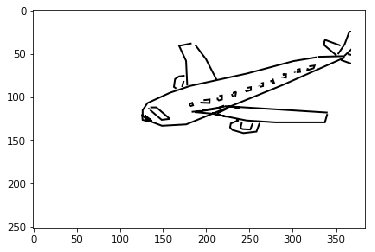

In [137]:
s = filepath+'.png'
im = io.imread(s)
plt.imshow(im)
plt.show()